In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "uni90"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 326
Categorical features: 10
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 398
Categorical Columns: 10


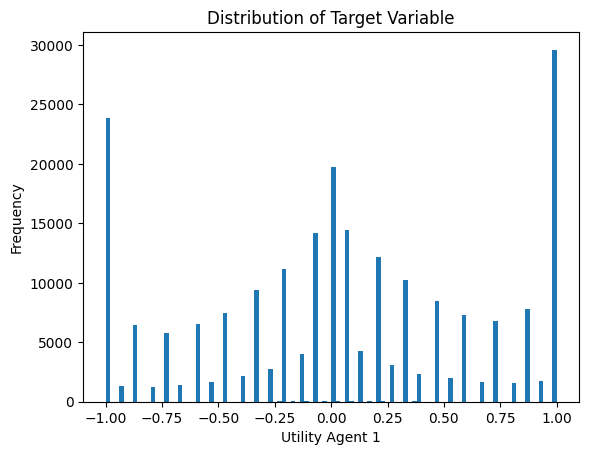

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.495813


[200]	valid_0's rmse: 0.480473


[300]	valid_0's rmse: 0.471866


[400]	valid_0's rmse: 0.465342


[500]	valid_0's rmse: 0.460254


[600]	valid_0's rmse: 0.456298


[700]	valid_0's rmse: 0.45324


[800]	valid_0's rmse: 0.450543


[900]	valid_0's rmse: 0.447995


[1000]	valid_0's rmse: 0.445966


[1100]	valid_0's rmse: 0.44392


[1200]	valid_0's rmse: 0.44258


[1300]	valid_0's rmse: 0.441368


[1400]	valid_0's rmse: 0.44024


[1500]	valid_0's rmse: 0.439246


[1600]	valid_0's rmse: 0.438532


[1700]	valid_0's rmse: 0.43797


[1800]	valid_0's rmse: 0.437193


[1900]	valid_0's rmse: 0.436849


[2000]	valid_0's rmse: 0.436219


[2100]	valid_0's rmse: 0.435819


[2200]	valid_0's rmse: 0.435462


[2300]	valid_0's rmse: 0.435096


[2400]	valid_0's rmse: 0.434749


[2500]	valid_0's rmse: 0.434385


[2600]	valid_0's rmse: 0.434104


[2700]	valid_0's rmse: 0.433889


[2800]	valid_0's rmse: 0.433602


[2900]	valid_0's rmse: 0.433347


[3000]	valid_0's rmse: 0.433165


[3100]	valid_0's rmse: 0.432861


[3200]	valid_0's rmse: 0.43261


[3300]	valid_0's rmse: 0.432416


[3400]	valid_0's rmse: 0.432177


[3500]	valid_0's rmse: 0.432022


[3600]	valid_0's rmse: 0.431816


[3700]	valid_0's rmse: 0.431641


[3800]	valid_0's rmse: 0.431482


[3900]	valid_0's rmse: 0.431248


[4000]	valid_0's rmse: 0.431104


[4100]	valid_0's rmse: 0.431017


[4200]	valid_0's rmse: 0.430955


[4300]	valid_0's rmse: 0.430749


[4400]	valid_0's rmse: 0.430542


[4500]	valid_0's rmse: 0.430431


[4600]	valid_0's rmse: 0.430337


[4700]	valid_0's rmse: 0.430212


[4800]	valid_0's rmse: 0.430117


[4900]	valid_0's rmse: 0.430062


[5000]	valid_0's rmse: 0.429958


[5100]	valid_0's rmse: 0.429914


[5200]	valid_0's rmse: 0.429859


[5300]	valid_0's rmse: 0.429726


[5400]	valid_0's rmse: 0.429653


[5500]	valid_0's rmse: 0.429545


[5600]	valid_0's rmse: 0.429481


[5700]	valid_0's rmse: 0.429335


[5800]	valid_0's rmse: 0.429244


[5900]	valid_0's rmse: 0.429135


[6000]	valid_0's rmse: 0.429077


[6100]	valid_0's rmse: 0.429065


[6200]	valid_0's rmse: 0.429043


[6300]	valid_0's rmse: 0.428944


[6400]	valid_0's rmse: 0.428871


[6500]	valid_0's rmse: 0.428838


[6600]	valid_0's rmse: 0.428793


[6700]	valid_0's rmse: 0.428716


[6800]	valid_0's rmse: 0.42863


[6900]	valid_0's rmse: 0.42854


[7000]	valid_0's rmse: 0.428516


[7100]	valid_0's rmse: 0.428539


[7200]	valid_0's rmse: 0.42849


[7300]	valid_0's rmse: 0.428463


[7400]	valid_0's rmse: 0.428471


[7500]	valid_0's rmse: 0.42841


[7600]	valid_0's rmse: 0.428389


[7700]	valid_0's rmse: 0.428347


[7800]	valid_0's rmse: 0.428367


[7900]	valid_0's rmse: 0.428363


[8000]	valid_0's rmse: 0.428339


[8100]	valid_0's rmse: 0.428323


[8200]	valid_0's rmse: 0.428335


[8300]	valid_0's rmse: 0.42825


[8400]	valid_0's rmse: 0.428191


[8500]	valid_0's rmse: 0.428205


[8600]	valid_0's rmse: 0.42827


[8700]	valid_0's rmse: 0.428222


[8800]	valid_0's rmse: 0.428177


[8900]	valid_0's rmse: 0.428137


[9000]	valid_0's rmse: 0.428169


[9100]	valid_0's rmse: 0.428138


[9200]	valid_0's rmse: 0.428136


[9300]	valid_0's rmse: 0.42818


[9400]	valid_0's rmse: 0.428193


[9500]	valid_0's rmse: 0.428203


[9600]	valid_0's rmse: 0.428203


[9700]	valid_0's rmse: 0.428209


[9800]	valid_0's rmse: 0.428206


[9900]	valid_0's rmse: 0.428181


[10000]	valid_0's rmse: 0.428162


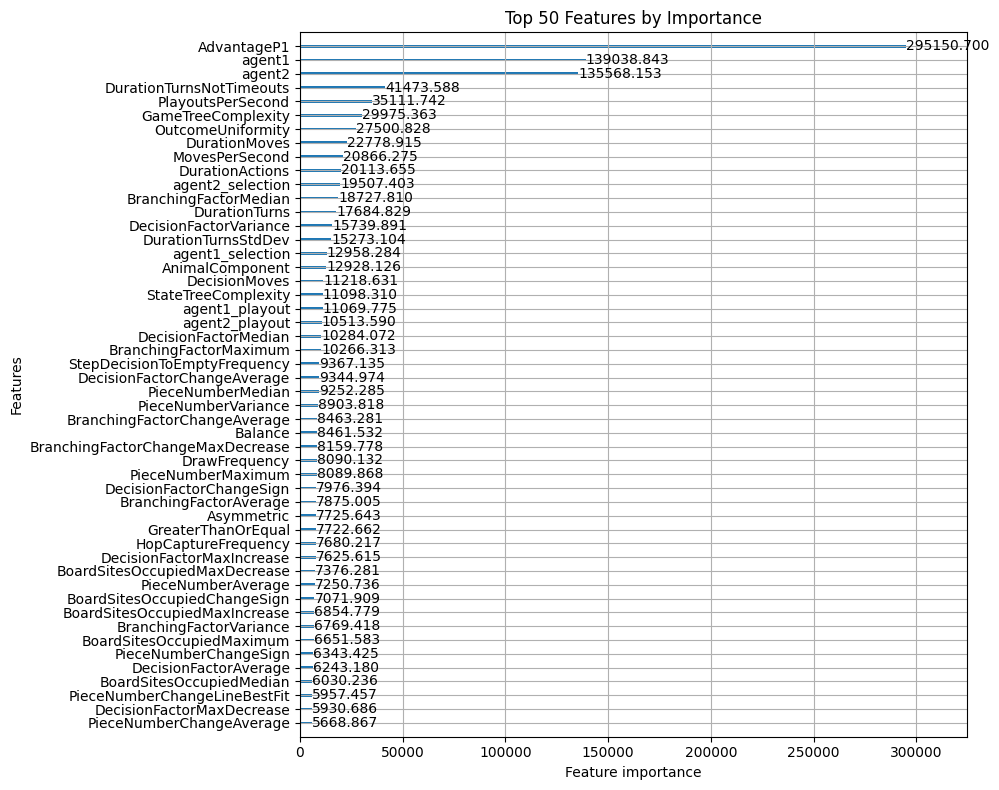

Fold 1 - RMSE: 0.42765031505165035
Fold 2


[100]	valid_0's rmse: 0.513272


[200]	valid_0's rmse: 0.498751


[300]	valid_0's rmse: 0.490619


[400]	valid_0's rmse: 0.484898


[500]	valid_0's rmse: 0.48108


[600]	valid_0's rmse: 0.478508


[700]	valid_0's rmse: 0.47592


[800]	valid_0's rmse: 0.474427


[900]	valid_0's rmse: 0.472711


[1000]	valid_0's rmse: 0.471197


[1100]	valid_0's rmse: 0.470241


[1200]	valid_0's rmse: 0.469213


[1300]	valid_0's rmse: 0.468271


[1400]	valid_0's rmse: 0.467456


[1500]	valid_0's rmse: 0.466787


[1600]	valid_0's rmse: 0.466168


[1700]	valid_0's rmse: 0.465398


[1800]	valid_0's rmse: 0.465007


[1900]	valid_0's rmse: 0.464365


[2000]	valid_0's rmse: 0.464013


[2100]	valid_0's rmse: 0.463466


[2200]	valid_0's rmse: 0.463022


[2300]	valid_0's rmse: 0.462628


[2400]	valid_0's rmse: 0.462204


[2500]	valid_0's rmse: 0.461929


[2600]	valid_0's rmse: 0.461586


[2700]	valid_0's rmse: 0.461192


[2800]	valid_0's rmse: 0.460899


[2900]	valid_0's rmse: 0.460563


[3000]	valid_0's rmse: 0.46035


[3100]	valid_0's rmse: 0.460086


[3200]	valid_0's rmse: 0.459767


[3300]	valid_0's rmse: 0.459651


[3400]	valid_0's rmse: 0.459438


[3500]	valid_0's rmse: 0.459302


[3600]	valid_0's rmse: 0.459056


[3700]	valid_0's rmse: 0.458788


[3800]	valid_0's rmse: 0.458648


[3900]	valid_0's rmse: 0.458406


[4000]	valid_0's rmse: 0.45832


[4100]	valid_0's rmse: 0.45827


[4200]	valid_0's rmse: 0.458161


[4300]	valid_0's rmse: 0.458033


[4400]	valid_0's rmse: 0.45789


[4500]	valid_0's rmse: 0.457869


[4600]	valid_0's rmse: 0.457708


[4700]	valid_0's rmse: 0.457646


[4800]	valid_0's rmse: 0.457547


[4900]	valid_0's rmse: 0.457451


[5000]	valid_0's rmse: 0.457417


[5100]	valid_0's rmse: 0.457325


[5200]	valid_0's rmse: 0.457199


[5300]	valid_0's rmse: 0.457107


[5400]	valid_0's rmse: 0.457005


[5500]	valid_0's rmse: 0.456909


[5600]	valid_0's rmse: 0.456803


[5700]	valid_0's rmse: 0.456686


[5800]	valid_0's rmse: 0.456471


[5900]	valid_0's rmse: 0.456355


[6000]	valid_0's rmse: 0.456269


[6100]	valid_0's rmse: 0.456213


[6200]	valid_0's rmse: 0.456186


[6300]	valid_0's rmse: 0.456163


[6400]	valid_0's rmse: 0.456067


[6500]	valid_0's rmse: 0.456008


[6600]	valid_0's rmse: 0.455954


[6700]	valid_0's rmse: 0.455887


[6800]	valid_0's rmse: 0.455791


[6900]	valid_0's rmse: 0.455702


[7000]	valid_0's rmse: 0.455653


[7100]	valid_0's rmse: 0.455608


[7200]	valid_0's rmse: 0.455483


[7300]	valid_0's rmse: 0.455412


[7400]	valid_0's rmse: 0.455419


[7500]	valid_0's rmse: 0.455343


[7600]	valid_0's rmse: 0.455216


[7700]	valid_0's rmse: 0.455205


[7800]	valid_0's rmse: 0.455051


[7900]	valid_0's rmse: 0.455028


[8000]	valid_0's rmse: 0.454996


[8100]	valid_0's rmse: 0.454987


[8200]	valid_0's rmse: 0.45495


[8300]	valid_0's rmse: 0.45494


[8400]	valid_0's rmse: 0.454961


[8500]	valid_0's rmse: 0.454916


[8600]	valid_0's rmse: 0.454931


[8700]	valid_0's rmse: 0.45488


[8800]	valid_0's rmse: 0.454878


[8900]	valid_0's rmse: 0.454885


[9000]	valid_0's rmse: 0.454829


[9100]	valid_0's rmse: 0.454801


[9200]	valid_0's rmse: 0.45478


[9300]	valid_0's rmse: 0.454784


[9400]	valid_0's rmse: 0.45476


[9500]	valid_0's rmse: 0.454768


[9600]	valid_0's rmse: 0.454785


[9700]	valid_0's rmse: 0.454711


[9800]	valid_0's rmse: 0.454654


[9900]	valid_0's rmse: 0.45466


[10000]	valid_0's rmse: 0.454671


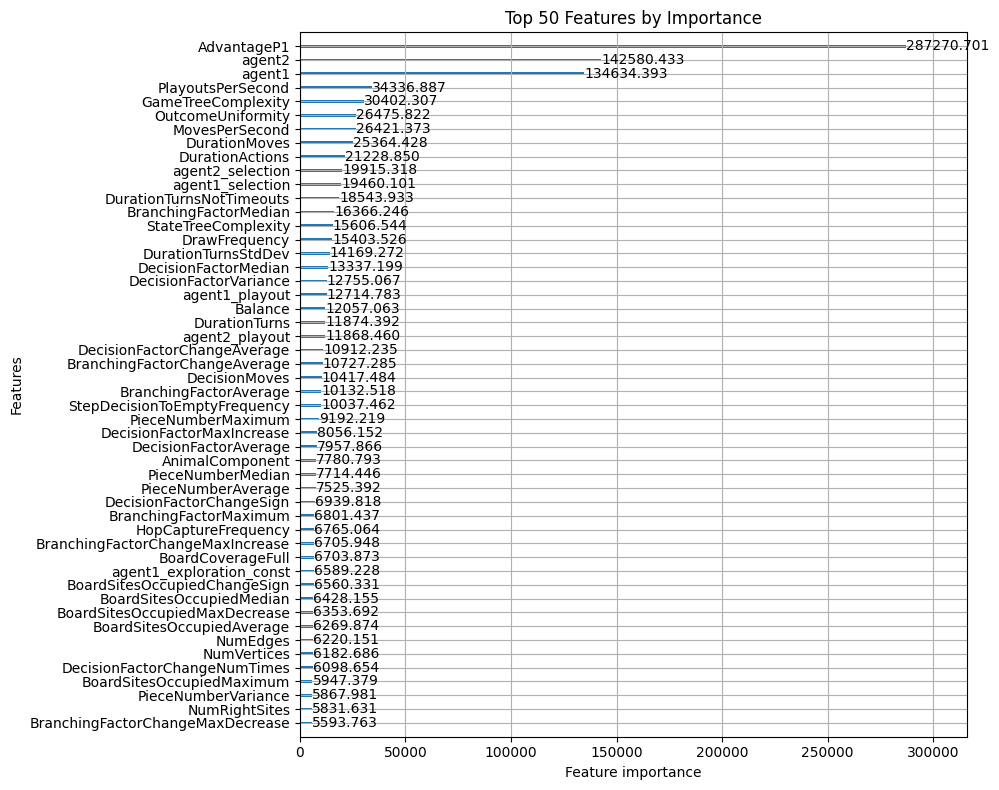

Fold 2 - RMSE: 0.4539780449711385
Fold 3


[100]	valid_0's rmse: 0.51141


[200]	valid_0's rmse: 0.483087


[300]	valid_0's rmse: 0.47367


[400]	valid_0's rmse: 0.467874


[500]	valid_0's rmse: 0.464867


[600]	valid_0's rmse: 0.461934


[700]	valid_0's rmse: 0.459703


[800]	valid_0's rmse: 0.457412


[900]	valid_0's rmse: 0.455665


[1000]	valid_0's rmse: 0.454235


[1100]	valid_0's rmse: 0.452743


[1200]	valid_0's rmse: 0.451484


[1300]	valid_0's rmse: 0.450425


[1400]	valid_0's rmse: 0.449696


[1500]	valid_0's rmse: 0.449117


[1600]	valid_0's rmse: 0.448442


[1700]	valid_0's rmse: 0.447676


[1800]	valid_0's rmse: 0.447227


[1900]	valid_0's rmse: 0.446732


[2000]	valid_0's rmse: 0.446308


[2100]	valid_0's rmse: 0.445973


[2200]	valid_0's rmse: 0.445636


[2300]	valid_0's rmse: 0.445275


[2400]	valid_0's rmse: 0.445071


[2500]	valid_0's rmse: 0.444788


[2600]	valid_0's rmse: 0.444531


[2700]	valid_0's rmse: 0.444369


[2800]	valid_0's rmse: 0.444101


[2900]	valid_0's rmse: 0.443818


[3000]	valid_0's rmse: 0.443549


[3100]	valid_0's rmse: 0.443326


[3200]	valid_0's rmse: 0.443118


[3300]	valid_0's rmse: 0.442824


[3400]	valid_0's rmse: 0.442629


[3500]	valid_0's rmse: 0.442467


[3600]	valid_0's rmse: 0.44233


[3700]	valid_0's rmse: 0.442224


[3800]	valid_0's rmse: 0.442157


[3900]	valid_0's rmse: 0.441955


[4000]	valid_0's rmse: 0.441899


[4100]	valid_0's rmse: 0.441752


[4200]	valid_0's rmse: 0.441598


[4300]	valid_0's rmse: 0.441508


[4400]	valid_0's rmse: 0.441388


[4500]	valid_0's rmse: 0.441307


[4600]	valid_0's rmse: 0.441154


[4700]	valid_0's rmse: 0.441044


[4800]	valid_0's rmse: 0.441104


[4900]	valid_0's rmse: 0.440974


[5000]	valid_0's rmse: 0.440877


[5100]	valid_0's rmse: 0.440719


[5200]	valid_0's rmse: 0.440548


[5300]	valid_0's rmse: 0.44044


[5400]	valid_0's rmse: 0.440325


[5500]	valid_0's rmse: 0.440284


[5600]	valid_0's rmse: 0.440304


[5700]	valid_0's rmse: 0.440286


[5800]	valid_0's rmse: 0.440245


[5900]	valid_0's rmse: 0.440159


[6000]	valid_0's rmse: 0.440066


[6100]	valid_0's rmse: 0.44005


[6200]	valid_0's rmse: 0.439951


[6300]	valid_0's rmse: 0.439913


[6400]	valid_0's rmse: 0.439899


[6500]	valid_0's rmse: 0.439877


[6600]	valid_0's rmse: 0.439901


[6700]	valid_0's rmse: 0.439803


[6800]	valid_0's rmse: 0.439739


[6900]	valid_0's rmse: 0.439641


[7000]	valid_0's rmse: 0.439564


[7100]	valid_0's rmse: 0.439521


[7200]	valid_0's rmse: 0.439434


[7300]	valid_0's rmse: 0.439507


[7400]	valid_0's rmse: 0.439508


[7500]	valid_0's rmse: 0.43945


[7600]	valid_0's rmse: 0.439417


[7700]	valid_0's rmse: 0.439365


[7800]	valid_0's rmse: 0.439358


[7900]	valid_0's rmse: 0.439342


[8000]	valid_0's rmse: 0.439364


[8100]	valid_0's rmse: 0.439314


[8200]	valid_0's rmse: 0.439327


[8300]	valid_0's rmse: 0.439305


[8400]	valid_0's rmse: 0.439298


[8500]	valid_0's rmse: 0.43925


[8600]	valid_0's rmse: 0.439219


[8700]	valid_0's rmse: 0.439197


[8800]	valid_0's rmse: 0.439105


[8900]	valid_0's rmse: 0.439088


[9000]	valid_0's rmse: 0.439052


[9100]	valid_0's rmse: 0.439059


[9200]	valid_0's rmse: 0.439019


[9300]	valid_0's rmse: 0.439008


[9400]	valid_0's rmse: 0.43897


[9500]	valid_0's rmse: 0.43894


[9600]	valid_0's rmse: 0.438888


[9700]	valid_0's rmse: 0.438859


[9800]	valid_0's rmse: 0.43883


[9900]	valid_0's rmse: 0.438823


[10000]	valid_0's rmse: 0.438785


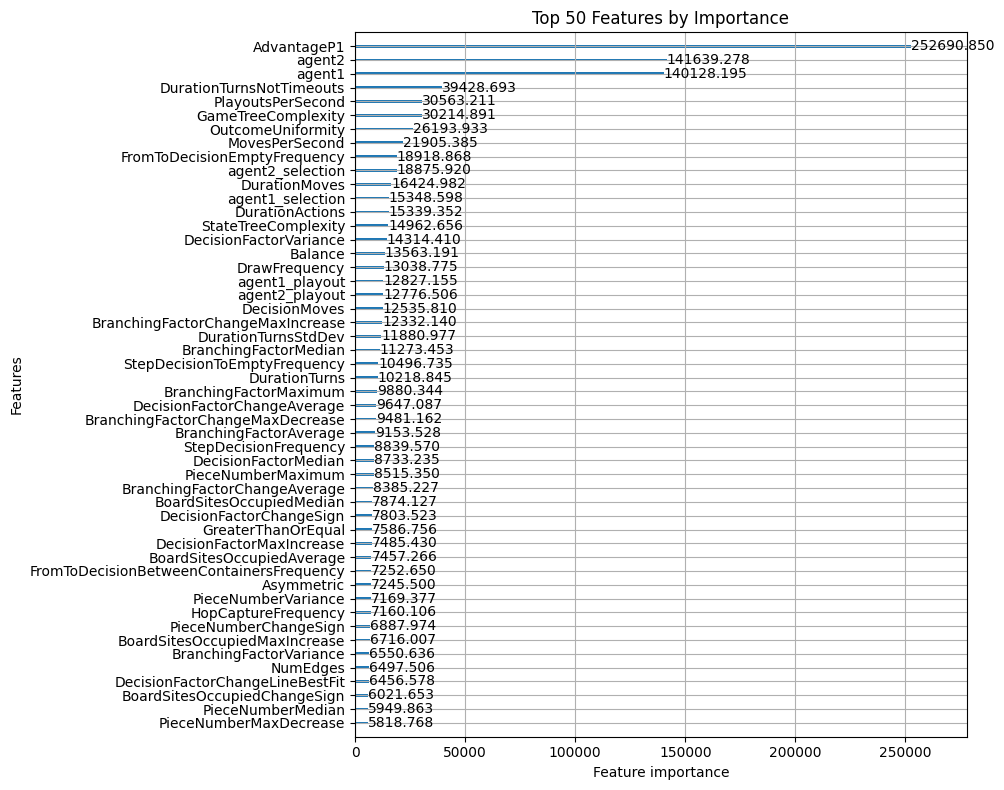

Fold 3 - RMSE: 0.4381867875713211
Fold 4


[100]	valid_0's rmse: 0.516077


[200]	valid_0's rmse: 0.493806


[300]	valid_0's rmse: 0.482813


[400]	valid_0's rmse: 0.474566


[500]	valid_0's rmse: 0.468703


[600]	valid_0's rmse: 0.465095


[700]	valid_0's rmse: 0.462172


[800]	valid_0's rmse: 0.459188


[900]	valid_0's rmse: 0.45711


[1000]	valid_0's rmse: 0.454965


[1100]	valid_0's rmse: 0.453404


[1200]	valid_0's rmse: 0.452165


[1300]	valid_0's rmse: 0.451278


[1400]	valid_0's rmse: 0.45048


[1500]	valid_0's rmse: 0.449755


[1600]	valid_0's rmse: 0.448838


[1700]	valid_0's rmse: 0.447985


[1800]	valid_0's rmse: 0.447315


[1900]	valid_0's rmse: 0.446877


[2000]	valid_0's rmse: 0.446382


[2100]	valid_0's rmse: 0.445881


[2200]	valid_0's rmse: 0.44544


[2300]	valid_0's rmse: 0.444987


[2400]	valid_0's rmse: 0.444585


[2500]	valid_0's rmse: 0.444165


[2600]	valid_0's rmse: 0.443849


[2700]	valid_0's rmse: 0.443675


[2800]	valid_0's rmse: 0.443379


[2900]	valid_0's rmse: 0.443073


[3000]	valid_0's rmse: 0.442803


[3100]	valid_0's rmse: 0.442598


[3200]	valid_0's rmse: 0.442319


[3300]	valid_0's rmse: 0.442072


[3400]	valid_0's rmse: 0.441843


[3500]	valid_0's rmse: 0.441598


[3600]	valid_0's rmse: 0.441386


[3700]	valid_0's rmse: 0.441172


[3800]	valid_0's rmse: 0.440918


[3900]	valid_0's rmse: 0.440671


[4000]	valid_0's rmse: 0.440473


[4100]	valid_0's rmse: 0.440252


[4200]	valid_0's rmse: 0.440069


[4300]	valid_0's rmse: 0.439938


[4400]	valid_0's rmse: 0.4398


[4500]	valid_0's rmse: 0.439648


[4600]	valid_0's rmse: 0.439541


[4700]	valid_0's rmse: 0.439484


[4800]	valid_0's rmse: 0.439493


[4900]	valid_0's rmse: 0.439407


[5000]	valid_0's rmse: 0.439269


[5100]	valid_0's rmse: 0.439125


[5200]	valid_0's rmse: 0.439032


[5300]	valid_0's rmse: 0.438976


[5400]	valid_0's rmse: 0.438833


[5500]	valid_0's rmse: 0.43865


[5600]	valid_0's rmse: 0.438609


[5700]	valid_0's rmse: 0.438457


[5800]	valid_0's rmse: 0.438432


[5900]	valid_0's rmse: 0.438403


[6000]	valid_0's rmse: 0.43836


[6100]	valid_0's rmse: 0.438326


[6200]	valid_0's rmse: 0.438367


[6300]	valid_0's rmse: 0.438314


[6400]	valid_0's rmse: 0.438315


[6500]	valid_0's rmse: 0.438262


[6600]	valid_0's rmse: 0.4382


[6700]	valid_0's rmse: 0.438187


[6800]	valid_0's rmse: 0.438154


[6900]	valid_0's rmse: 0.438096


[7000]	valid_0's rmse: 0.438048


[7100]	valid_0's rmse: 0.43799


[7200]	valid_0's rmse: 0.437981


[7300]	valid_0's rmse: 0.437897


[7400]	valid_0's rmse: 0.43788


[7500]	valid_0's rmse: 0.437896


[7600]	valid_0's rmse: 0.437877


[7700]	valid_0's rmse: 0.437863


[7800]	valid_0's rmse: 0.43778


[7900]	valid_0's rmse: 0.437752


[8000]	valid_0's rmse: 0.437742


[8100]	valid_0's rmse: 0.437672


[8200]	valid_0's rmse: 0.437638


[8300]	valid_0's rmse: 0.437621


[8400]	valid_0's rmse: 0.437552


[8500]	valid_0's rmse: 0.437541


[8600]	valid_0's rmse: 0.437472


[8700]	valid_0's rmse: 0.437432


[8800]	valid_0's rmse: 0.437411


[8900]	valid_0's rmse: 0.437372


[9000]	valid_0's rmse: 0.437355


[9100]	valid_0's rmse: 0.437351


[9200]	valid_0's rmse: 0.437287


[9300]	valid_0's rmse: 0.43731


[9400]	valid_0's rmse: 0.437244


[9500]	valid_0's rmse: 0.437226


[9600]	valid_0's rmse: 0.437184


[9700]	valid_0's rmse: 0.437157


[9800]	valid_0's rmse: 0.437137


[9900]	valid_0's rmse: 0.437095


[10000]	valid_0's rmse: 0.437068


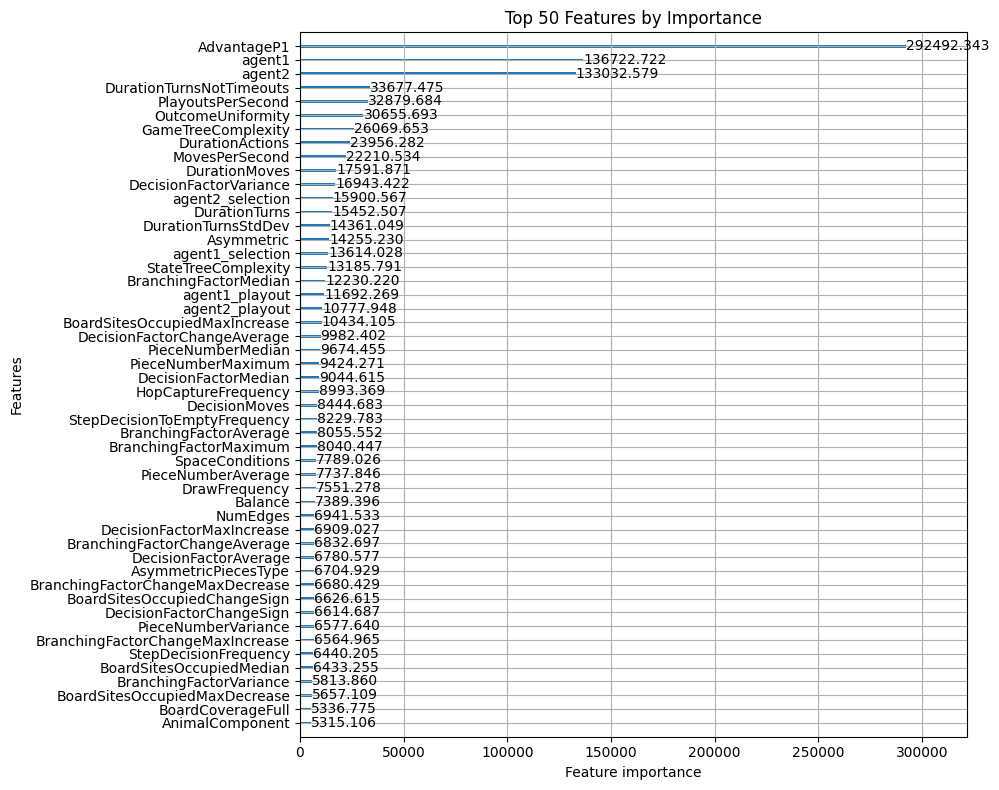

Fold 4 - RMSE: 0.43621031543376376
Fold 5


[100]	valid_0's rmse: 0.486688


[200]	valid_0's rmse: 0.466952


[300]	valid_0's rmse: 0.455429


[400]	valid_0's rmse: 0.446512


[500]	valid_0's rmse: 0.440707


[600]	valid_0's rmse: 0.436392


[700]	valid_0's rmse: 0.432577


[800]	valid_0's rmse: 0.429647


[900]	valid_0's rmse: 0.427163


[1000]	valid_0's rmse: 0.425447


[1100]	valid_0's rmse: 0.423703


[1200]	valid_0's rmse: 0.422378


[1300]	valid_0's rmse: 0.421157


[1400]	valid_0's rmse: 0.420175


[1500]	valid_0's rmse: 0.419093


[1600]	valid_0's rmse: 0.418465


[1700]	valid_0's rmse: 0.417853


[1800]	valid_0's rmse: 0.417255


[1900]	valid_0's rmse: 0.416545


[2000]	valid_0's rmse: 0.416047


[2100]	valid_0's rmse: 0.415577


[2200]	valid_0's rmse: 0.41519


[2300]	valid_0's rmse: 0.414827


[2400]	valid_0's rmse: 0.414363


[2500]	valid_0's rmse: 0.414012


[2600]	valid_0's rmse: 0.413476


[2700]	valid_0's rmse: 0.413175


[2800]	valid_0's rmse: 0.412945


[2900]	valid_0's rmse: 0.412555


[3000]	valid_0's rmse: 0.41234


[3100]	valid_0's rmse: 0.412193


[3200]	valid_0's rmse: 0.41201


[3300]	valid_0's rmse: 0.411697


[3400]	valid_0's rmse: 0.411483


[3500]	valid_0's rmse: 0.411295


[3600]	valid_0's rmse: 0.411105


[3700]	valid_0's rmse: 0.410962


[3800]	valid_0's rmse: 0.410703


[3900]	valid_0's rmse: 0.41058


[4000]	valid_0's rmse: 0.410525


[4100]	valid_0's rmse: 0.410383


[4200]	valid_0's rmse: 0.410309


[4300]	valid_0's rmse: 0.41024


[4400]	valid_0's rmse: 0.410158


[4500]	valid_0's rmse: 0.409995


[4600]	valid_0's rmse: 0.409843


[4700]	valid_0's rmse: 0.409751


[4800]	valid_0's rmse: 0.409697


[4900]	valid_0's rmse: 0.409579


[5000]	valid_0's rmse: 0.409529


[5100]	valid_0's rmse: 0.40944


[5200]	valid_0's rmse: 0.409346


[5300]	valid_0's rmse: 0.409324


[5400]	valid_0's rmse: 0.409349


[5500]	valid_0's rmse: 0.409305


[5600]	valid_0's rmse: 0.409275


[5700]	valid_0's rmse: 0.409235


[5800]	valid_0's rmse: 0.409207


[5900]	valid_0's rmse: 0.409151


[6000]	valid_0's rmse: 0.409106


[6100]	valid_0's rmse: 0.409076


[6200]	valid_0's rmse: 0.40904


[6300]	valid_0's rmse: 0.408911


[6400]	valid_0's rmse: 0.408864


[6500]	valid_0's rmse: 0.40892


[6600]	valid_0's rmse: 0.408852


[6700]	valid_0's rmse: 0.408842


[6800]	valid_0's rmse: 0.408756


[6900]	valid_0's rmse: 0.408791


[7000]	valid_0's rmse: 0.408812


[7100]	valid_0's rmse: 0.408818


[7200]	valid_0's rmse: 0.408737


[7300]	valid_0's rmse: 0.408677


[7400]	valid_0's rmse: 0.408662


[7500]	valid_0's rmse: 0.408628


[7600]	valid_0's rmse: 0.408646


[7700]	valid_0's rmse: 0.408552


[7800]	valid_0's rmse: 0.408605


[7900]	valid_0's rmse: 0.408578


[8000]	valid_0's rmse: 0.40859


[8100]	valid_0's rmse: 0.408586


[8200]	valid_0's rmse: 0.408572


[8300]	valid_0's rmse: 0.408567


[8400]	valid_0's rmse: 0.408513


[8500]	valid_0's rmse: 0.408477


[8600]	valid_0's rmse: 0.408456


[8700]	valid_0's rmse: 0.408416


[8800]	valid_0's rmse: 0.408387


[8900]	valid_0's rmse: 0.408349


[9000]	valid_0's rmse: 0.408412


[9100]	valid_0's rmse: 0.408433


[9200]	valid_0's rmse: 0.408408


[9300]	valid_0's rmse: 0.408411


[9400]	valid_0's rmse: 0.408372


[9500]	valid_0's rmse: 0.408411


[9600]	valid_0's rmse: 0.408367


[9700]	valid_0's rmse: 0.408313


[9800]	valid_0's rmse: 0.408288


[9900]	valid_0's rmse: 0.408251


[10000]	valid_0's rmse: 0.408242


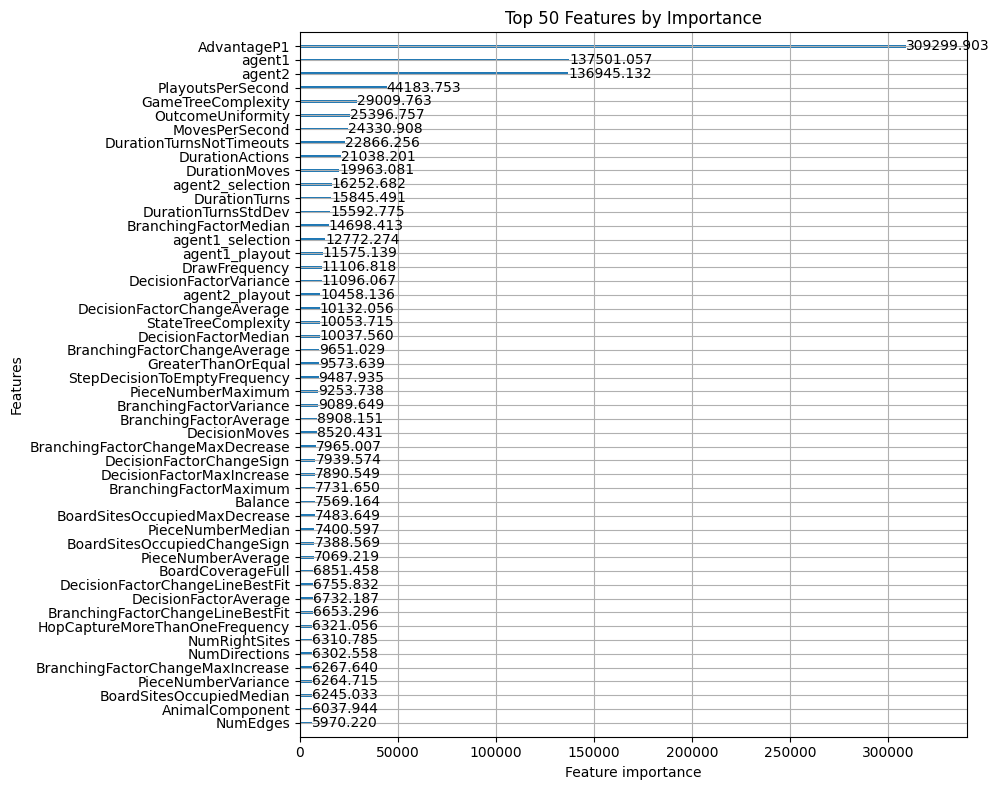

Fold 5 - RMSE: 0.4078195236836637
List of oof scores: [0.42765031505165035, 0.4539780449711385, 0.4381867875713211, 0.43621031543376376, 0.4078195236836637]
Average oof score: 0.4327689973423075


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.476557


[200]	valid_0's rmse: 0.458052


[300]	valid_0's rmse: 0.447599


[400]	valid_0's rmse: 0.44164


[500]	valid_0's rmse: 0.437826


[600]	valid_0's rmse: 0.434533


[700]	valid_0's rmse: 0.432307


[800]	valid_0's rmse: 0.429991


[900]	valid_0's rmse: 0.428237


[1000]	valid_0's rmse: 0.426825


[1100]	valid_0's rmse: 0.425814


[1200]	valid_0's rmse: 0.42493


[1300]	valid_0's rmse: 0.42403


[1400]	valid_0's rmse: 0.423311


[1500]	valid_0's rmse: 0.422612


[1600]	valid_0's rmse: 0.421999


[1700]	valid_0's rmse: 0.421419


[1800]	valid_0's rmse: 0.42101


[1900]	valid_0's rmse: 0.420503


[2000]	valid_0's rmse: 0.420072


[2100]	valid_0's rmse: 0.419623


[2200]	valid_0's rmse: 0.419129


[2300]	valid_0's rmse: 0.418619


[2400]	valid_0's rmse: 0.418307


[2500]	valid_0's rmse: 0.417991


[2600]	valid_0's rmse: 0.417648


[2700]	valid_0's rmse: 0.417452


[2800]	valid_0's rmse: 0.417172


[2900]	valid_0's rmse: 0.416832


[3000]	valid_0's rmse: 0.416527


[3100]	valid_0's rmse: 0.41621


[3200]	valid_0's rmse: 0.415952


[3300]	valid_0's rmse: 0.415797


[3400]	valid_0's rmse: 0.415606


[3500]	valid_0's rmse: 0.415526


[3600]	valid_0's rmse: 0.415173


[3700]	valid_0's rmse: 0.414974


[3800]	valid_0's rmse: 0.41486


[3900]	valid_0's rmse: 0.414671


[4000]	valid_0's rmse: 0.414512


[4100]	valid_0's rmse: 0.414355


[4200]	valid_0's rmse: 0.41421


[4300]	valid_0's rmse: 0.414017


[4400]	valid_0's rmse: 0.413939


[4500]	valid_0's rmse: 0.413807


[4600]	valid_0's rmse: 0.413629


[4700]	valid_0's rmse: 0.413547


[4800]	valid_0's rmse: 0.413462


[4900]	valid_0's rmse: 0.4134


[5000]	valid_0's rmse: 0.413263


[5100]	valid_0's rmse: 0.413041


[5200]	valid_0's rmse: 0.412841


[5300]	valid_0's rmse: 0.412753


[5400]	valid_0's rmse: 0.412656


[5500]	valid_0's rmse: 0.412551


[5600]	valid_0's rmse: 0.412475


[5700]	valid_0's rmse: 0.412432


[5800]	valid_0's rmse: 0.412318


[5900]	valid_0's rmse: 0.412167


[6000]	valid_0's rmse: 0.41213


[6100]	valid_0's rmse: 0.412054


[6200]	valid_0's rmse: 0.411969


[6300]	valid_0's rmse: 0.411872


[6400]	valid_0's rmse: 0.411762


[6500]	valid_0's rmse: 0.411667


[6600]	valid_0's rmse: 0.411667


[6700]	valid_0's rmse: 0.411623


[6800]	valid_0's rmse: 0.411524


[6900]	valid_0's rmse: 0.411379


[7000]	valid_0's rmse: 0.411279


[7100]	valid_0's rmse: 0.411247


[7200]	valid_0's rmse: 0.411177


[7300]	valid_0's rmse: 0.411121


[7400]	valid_0's rmse: 0.411014


[7500]	valid_0's rmse: 0.41103


[7600]	valid_0's rmse: 0.410995


[7700]	valid_0's rmse: 0.410938


[7800]	valid_0's rmse: 0.410875


[7900]	valid_0's rmse: 0.410886


[8000]	valid_0's rmse: 0.410869


[8100]	valid_0's rmse: 0.410835


[8200]	valid_0's rmse: 0.410764


[8300]	valid_0's rmse: 0.410692


[8400]	valid_0's rmse: 0.41061


[8500]	valid_0's rmse: 0.410606


[8600]	valid_0's rmse: 0.410589


[8700]	valid_0's rmse: 0.410591


[8800]	valid_0's rmse: 0.410553


[8900]	valid_0's rmse: 0.410494


[9000]	valid_0's rmse: 0.410489


[9100]	valid_0's rmse: 0.410463


[9200]	valid_0's rmse: 0.410389


[9300]	valid_0's rmse: 0.410369


[9400]	valid_0's rmse: 0.410343


[9500]	valid_0's rmse: 0.410257


[9600]	valid_0's rmse: 0.410197


[9700]	valid_0's rmse: 0.41021


[9800]	valid_0's rmse: 0.410235


[9900]	valid_0's rmse: 0.410228


[10000]	valid_0's rmse: 0.41019


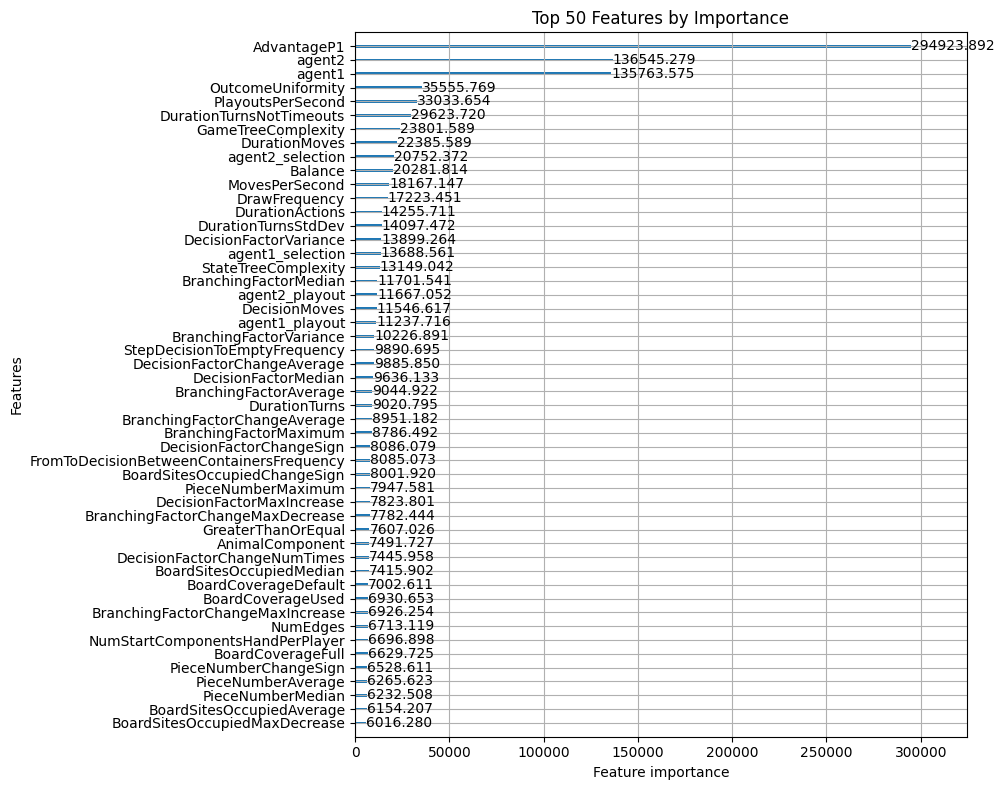

Fold 1 - RMSE: 0.4097489747371242
Fold 2


[100]	valid_0's rmse: 0.460452


[200]	valid_0's rmse: 0.44033


[300]	valid_0's rmse: 0.431311


[400]	valid_0's rmse: 0.426941


[500]	valid_0's rmse: 0.422969


[600]	valid_0's rmse: 0.420508


[700]	valid_0's rmse: 0.418482


[800]	valid_0's rmse: 0.416847


[900]	valid_0's rmse: 0.415385


[1000]	valid_0's rmse: 0.414263


[1100]	valid_0's rmse: 0.412997


[1200]	valid_0's rmse: 0.4121


[1300]	valid_0's rmse: 0.411197


[1400]	valid_0's rmse: 0.410675


[1500]	valid_0's rmse: 0.410076


[1600]	valid_0's rmse: 0.409496


[1700]	valid_0's rmse: 0.409024


[1800]	valid_0's rmse: 0.408434


[1900]	valid_0's rmse: 0.407997


[2000]	valid_0's rmse: 0.407557


[2100]	valid_0's rmse: 0.407449


[2200]	valid_0's rmse: 0.407154


[2300]	valid_0's rmse: 0.407003


[2400]	valid_0's rmse: 0.406736


[2500]	valid_0's rmse: 0.406378


[2600]	valid_0's rmse: 0.406138


[2700]	valid_0's rmse: 0.406005


[2800]	valid_0's rmse: 0.405858


[2900]	valid_0's rmse: 0.405723


[3000]	valid_0's rmse: 0.405576


[3100]	valid_0's rmse: 0.405403


[3200]	valid_0's rmse: 0.405221


[3300]	valid_0's rmse: 0.405115


[3400]	valid_0's rmse: 0.40491


[3500]	valid_0's rmse: 0.404789


[3600]	valid_0's rmse: 0.404688


[3700]	valid_0's rmse: 0.404649


[3800]	valid_0's rmse: 0.40458


[3900]	valid_0's rmse: 0.404524


[4000]	valid_0's rmse: 0.404435


[4100]	valid_0's rmse: 0.404343


[4200]	valid_0's rmse: 0.404317


[4300]	valid_0's rmse: 0.404234


[4400]	valid_0's rmse: 0.404094


[4500]	valid_0's rmse: 0.403997


[4600]	valid_0's rmse: 0.403947


[4700]	valid_0's rmse: 0.40388


[4800]	valid_0's rmse: 0.403694


[4900]	valid_0's rmse: 0.403672


[5000]	valid_0's rmse: 0.403595


[5100]	valid_0's rmse: 0.403592


[5200]	valid_0's rmse: 0.403643


[5300]	valid_0's rmse: 0.403655


[5400]	valid_0's rmse: 0.40366


[5500]	valid_0's rmse: 0.40361


[5600]	valid_0's rmse: 0.403529


[5700]	valid_0's rmse: 0.403483


[5800]	valid_0's rmse: 0.403464


[5900]	valid_0's rmse: 0.40339


[6000]	valid_0's rmse: 0.403442


[6100]	valid_0's rmse: 0.403326


[6200]	valid_0's rmse: 0.403253


[6300]	valid_0's rmse: 0.403227


[6400]	valid_0's rmse: 0.403264


[6500]	valid_0's rmse: 0.403244


[6600]	valid_0's rmse: 0.403233


[6700]	valid_0's rmse: 0.403249


[6800]	valid_0's rmse: 0.403251


[6900]	valid_0's rmse: 0.403184


[7000]	valid_0's rmse: 0.40322


[7100]	valid_0's rmse: 0.403231


[7200]	valid_0's rmse: 0.403256


[7300]	valid_0's rmse: 0.403318


[7400]	valid_0's rmse: 0.403221


[7500]	valid_0's rmse: 0.40324


[7600]	valid_0's rmse: 0.403282


[7700]	valid_0's rmse: 0.40328


[7800]	valid_0's rmse: 0.403285


[7900]	valid_0's rmse: 0.403299


[8000]	valid_0's rmse: 0.403377


[8100]	valid_0's rmse: 0.403385


[8200]	valid_0's rmse: 0.403358


[8300]	valid_0's rmse: 0.403303


[8400]	valid_0's rmse: 0.403329


[8500]	valid_0's rmse: 0.403313


[8600]	valid_0's rmse: 0.40328


[8700]	valid_0's rmse: 0.403249


[8800]	valid_0's rmse: 0.403267


[8900]	valid_0's rmse: 0.403253


[9000]	valid_0's rmse: 0.40328


[9100]	valid_0's rmse: 0.403229


[9200]	valid_0's rmse: 0.40325


[9300]	valid_0's rmse: 0.403274


[9400]	valid_0's rmse: 0.403322


[9500]	valid_0's rmse: 0.403331


[9600]	valid_0's rmse: 0.403325


[9700]	valid_0's rmse: 0.403362


[9800]	valid_0's rmse: 0.403402


[9900]	valid_0's rmse: 0.403355


[10000]	valid_0's rmse: 0.403397


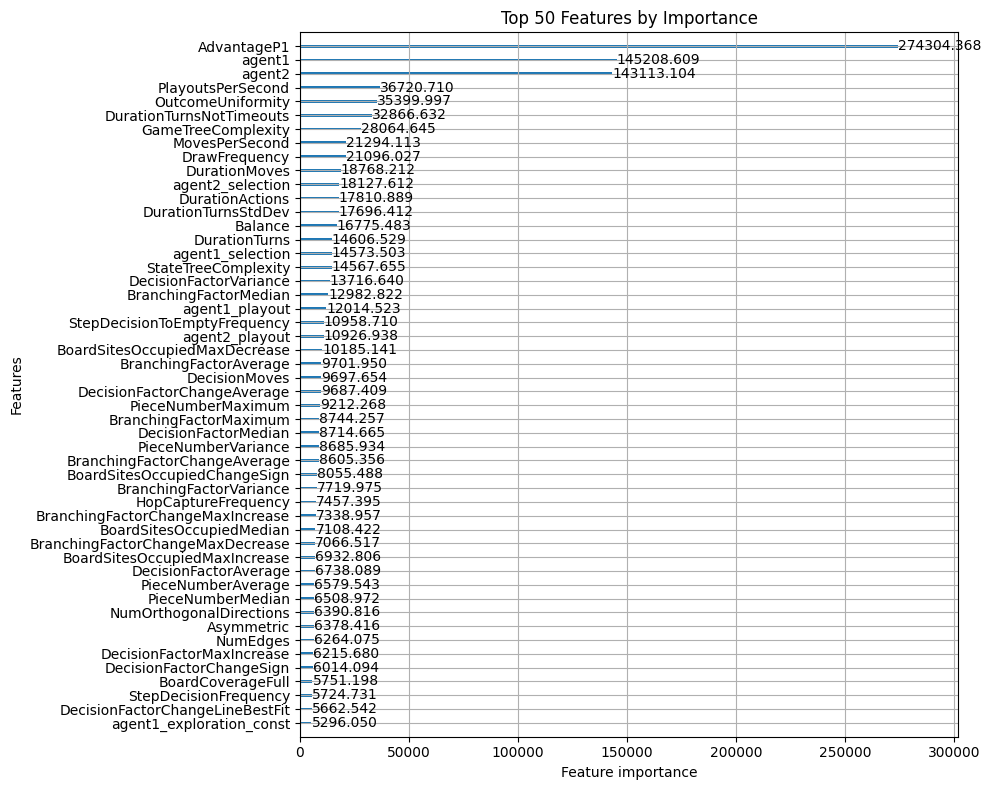

Fold 2 - RMSE: 0.40266278750767576
Fold 3


[100]	valid_0's rmse: 0.524707


[200]	valid_0's rmse: 0.498669


[300]	valid_0's rmse: 0.485977


[400]	valid_0's rmse: 0.478406


[500]	valid_0's rmse: 0.473341


[600]	valid_0's rmse: 0.468887


[700]	valid_0's rmse: 0.465818


[800]	valid_0's rmse: 0.462524


[900]	valid_0's rmse: 0.460044


[1000]	valid_0's rmse: 0.457933


[1100]	valid_0's rmse: 0.456125


[1200]	valid_0's rmse: 0.454425


[1300]	valid_0's rmse: 0.453147


[1400]	valid_0's rmse: 0.452102


[1500]	valid_0's rmse: 0.451065


[1600]	valid_0's rmse: 0.450269


[1700]	valid_0's rmse: 0.449445


[1800]	valid_0's rmse: 0.448784


[1900]	valid_0's rmse: 0.448087


[2000]	valid_0's rmse: 0.447553


[2100]	valid_0's rmse: 0.446993


[2200]	valid_0's rmse: 0.446357


[2300]	valid_0's rmse: 0.445944


[2400]	valid_0's rmse: 0.445575


[2500]	valid_0's rmse: 0.445054


[2600]	valid_0's rmse: 0.444731


[2700]	valid_0's rmse: 0.444319


[2800]	valid_0's rmse: 0.443973


[2900]	valid_0's rmse: 0.443651


[3000]	valid_0's rmse: 0.443305


[3100]	valid_0's rmse: 0.443025


[3200]	valid_0's rmse: 0.442755


[3300]	valid_0's rmse: 0.442556


[3400]	valid_0's rmse: 0.442286


[3500]	valid_0's rmse: 0.442128


[3600]	valid_0's rmse: 0.441969


[3700]	valid_0's rmse: 0.441684


[3800]	valid_0's rmse: 0.441468


[3900]	valid_0's rmse: 0.441336


[4000]	valid_0's rmse: 0.441093


[4100]	valid_0's rmse: 0.440881


[4200]	valid_0's rmse: 0.440694


[4300]	valid_0's rmse: 0.44057


[4400]	valid_0's rmse: 0.440501


[4500]	valid_0's rmse: 0.440374


[4600]	valid_0's rmse: 0.440197


[4700]	valid_0's rmse: 0.440062


[4800]	valid_0's rmse: 0.439914


[4900]	valid_0's rmse: 0.439796


[5000]	valid_0's rmse: 0.439723


[5100]	valid_0's rmse: 0.439576


[5200]	valid_0's rmse: 0.439509


[5300]	valid_0's rmse: 0.439352


[5400]	valid_0's rmse: 0.43929


[5500]	valid_0's rmse: 0.439193


[5600]	valid_0's rmse: 0.43916


[5700]	valid_0's rmse: 0.439055


[5800]	valid_0's rmse: 0.439001


[5900]	valid_0's rmse: 0.438864


[6000]	valid_0's rmse: 0.438775


[6100]	valid_0's rmse: 0.438749


[6200]	valid_0's rmse: 0.43864


[6300]	valid_0's rmse: 0.438488


[6400]	valid_0's rmse: 0.438418


[6500]	valid_0's rmse: 0.438342


[6600]	valid_0's rmse: 0.438285


[6700]	valid_0's rmse: 0.438208


[6800]	valid_0's rmse: 0.43821


[6900]	valid_0's rmse: 0.438145


[7000]	valid_0's rmse: 0.438077


[7100]	valid_0's rmse: 0.43801


[7200]	valid_0's rmse: 0.437932


[7300]	valid_0's rmse: 0.437946


[7400]	valid_0's rmse: 0.437919


[7500]	valid_0's rmse: 0.437874


[7600]	valid_0's rmse: 0.437795


[7700]	valid_0's rmse: 0.437829


[7800]	valid_0's rmse: 0.437801


[7900]	valid_0's rmse: 0.437716


[8000]	valid_0's rmse: 0.437671


[8100]	valid_0's rmse: 0.437507


[8200]	valid_0's rmse: 0.437509


[8300]	valid_0's rmse: 0.437469


[8400]	valid_0's rmse: 0.437451


[8500]	valid_0's rmse: 0.43742


[8600]	valid_0's rmse: 0.437411


[8700]	valid_0's rmse: 0.437306


[8800]	valid_0's rmse: 0.437328


[8900]	valid_0's rmse: 0.437318


[9000]	valid_0's rmse: 0.437248


[9100]	valid_0's rmse: 0.437195


[9200]	valid_0's rmse: 0.437168


[9300]	valid_0's rmse: 0.437128


[9400]	valid_0's rmse: 0.437063


[9500]	valid_0's rmse: 0.437004


[9600]	valid_0's rmse: 0.436992


[9700]	valid_0's rmse: 0.437011


[9800]	valid_0's rmse: 0.436977


[9900]	valid_0's rmse: 0.436934


[10000]	valid_0's rmse: 0.43688


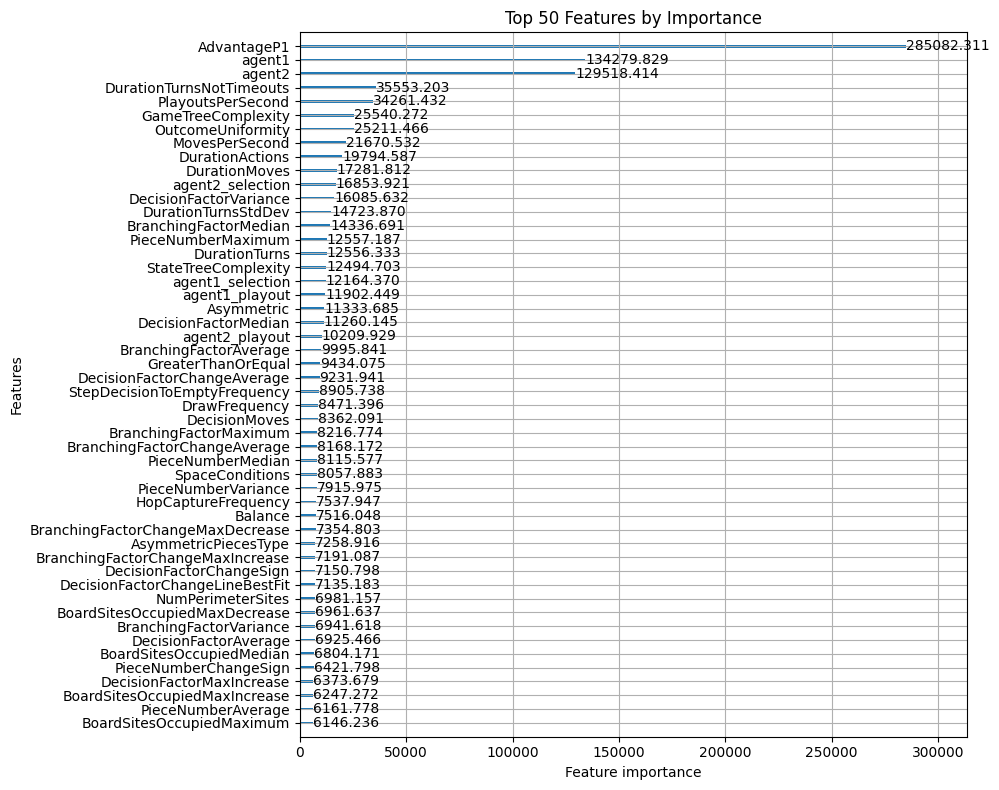

Fold 3 - RMSE: 0.4359347133237793
Fold 4


[100]	valid_0's rmse: 0.521631


[200]	valid_0's rmse: 0.495592


[300]	valid_0's rmse: 0.482895


[400]	valid_0's rmse: 0.474777


[500]	valid_0's rmse: 0.46806


[600]	valid_0's rmse: 0.464927


[700]	valid_0's rmse: 0.46228


[800]	valid_0's rmse: 0.459397


[900]	valid_0's rmse: 0.457424


[1000]	valid_0's rmse: 0.455665


[1100]	valid_0's rmse: 0.454055


[1200]	valid_0's rmse: 0.452886


[1300]	valid_0's rmse: 0.451755


[1400]	valid_0's rmse: 0.450742


[1500]	valid_0's rmse: 0.450081


[1600]	valid_0's rmse: 0.449299


[1700]	valid_0's rmse: 0.448851


[1800]	valid_0's rmse: 0.448289


[1900]	valid_0's rmse: 0.447801


[2000]	valid_0's rmse: 0.447198


[2100]	valid_0's rmse: 0.446741


[2200]	valid_0's rmse: 0.446383


[2300]	valid_0's rmse: 0.44613


[2400]	valid_0's rmse: 0.445723


[2500]	valid_0's rmse: 0.445444


[2600]	valid_0's rmse: 0.445228


[2700]	valid_0's rmse: 0.444791


[2800]	valid_0's rmse: 0.444498


[2900]	valid_0's rmse: 0.444254


[3000]	valid_0's rmse: 0.444057


[3100]	valid_0's rmse: 0.443865


[3200]	valid_0's rmse: 0.443681


[3300]	valid_0's rmse: 0.443483


[3400]	valid_0's rmse: 0.443363


[3500]	valid_0's rmse: 0.443147


[3600]	valid_0's rmse: 0.442969


[3700]	valid_0's rmse: 0.442743


[3800]	valid_0's rmse: 0.442591


[3900]	valid_0's rmse: 0.442473


[4000]	valid_0's rmse: 0.442342


[4100]	valid_0's rmse: 0.442254


[4200]	valid_0's rmse: 0.442096


[4300]	valid_0's rmse: 0.442017


[4400]	valid_0's rmse: 0.441971


[4500]	valid_0's rmse: 0.441767


[4600]	valid_0's rmse: 0.441685


[4700]	valid_0's rmse: 0.441621


[4800]	valid_0's rmse: 0.441472


[4900]	valid_0's rmse: 0.441511


[5000]	valid_0's rmse: 0.441438


[5100]	valid_0's rmse: 0.441407


[5200]	valid_0's rmse: 0.44135


[5300]	valid_0's rmse: 0.441328


[5400]	valid_0's rmse: 0.441141


[5500]	valid_0's rmse: 0.441096


[5600]	valid_0's rmse: 0.440943


[5700]	valid_0's rmse: 0.440859


[5800]	valid_0's rmse: 0.44077


[5900]	valid_0's rmse: 0.440651


[6000]	valid_0's rmse: 0.440525


[6100]	valid_0's rmse: 0.440425


[6200]	valid_0's rmse: 0.440398


[6300]	valid_0's rmse: 0.440352


[6400]	valid_0's rmse: 0.440287


[6500]	valid_0's rmse: 0.440204


[6600]	valid_0's rmse: 0.440117


[6700]	valid_0's rmse: 0.440101


[6800]	valid_0's rmse: 0.44005


[6900]	valid_0's rmse: 0.439971


[7000]	valid_0's rmse: 0.439953


[7100]	valid_0's rmse: 0.439872


[7200]	valid_0's rmse: 0.439838


[7300]	valid_0's rmse: 0.439805


[7400]	valid_0's rmse: 0.439834


[7500]	valid_0's rmse: 0.439762


[7600]	valid_0's rmse: 0.439648


[7700]	valid_0's rmse: 0.43962


[7800]	valid_0's rmse: 0.439616


[7900]	valid_0's rmse: 0.439563


[8000]	valid_0's rmse: 0.439545


[8100]	valid_0's rmse: 0.439562


[8200]	valid_0's rmse: 0.439526


[8300]	valid_0's rmse: 0.439479


[8400]	valid_0's rmse: 0.439465


[8500]	valid_0's rmse: 0.439451


[8600]	valid_0's rmse: 0.43936


[8700]	valid_0's rmse: 0.439339


[8800]	valid_0's rmse: 0.43932


[8900]	valid_0's rmse: 0.439303


[9000]	valid_0's rmse: 0.439327


[9100]	valid_0's rmse: 0.439368


[9200]	valid_0's rmse: 0.43933


[9300]	valid_0's rmse: 0.439297


[9400]	valid_0's rmse: 0.439282


[9500]	valid_0's rmse: 0.439165


[9600]	valid_0's rmse: 0.439153


[9700]	valid_0's rmse: 0.439134


[9800]	valid_0's rmse: 0.43914


[9900]	valid_0's rmse: 0.439078


[10000]	valid_0's rmse: 0.439084


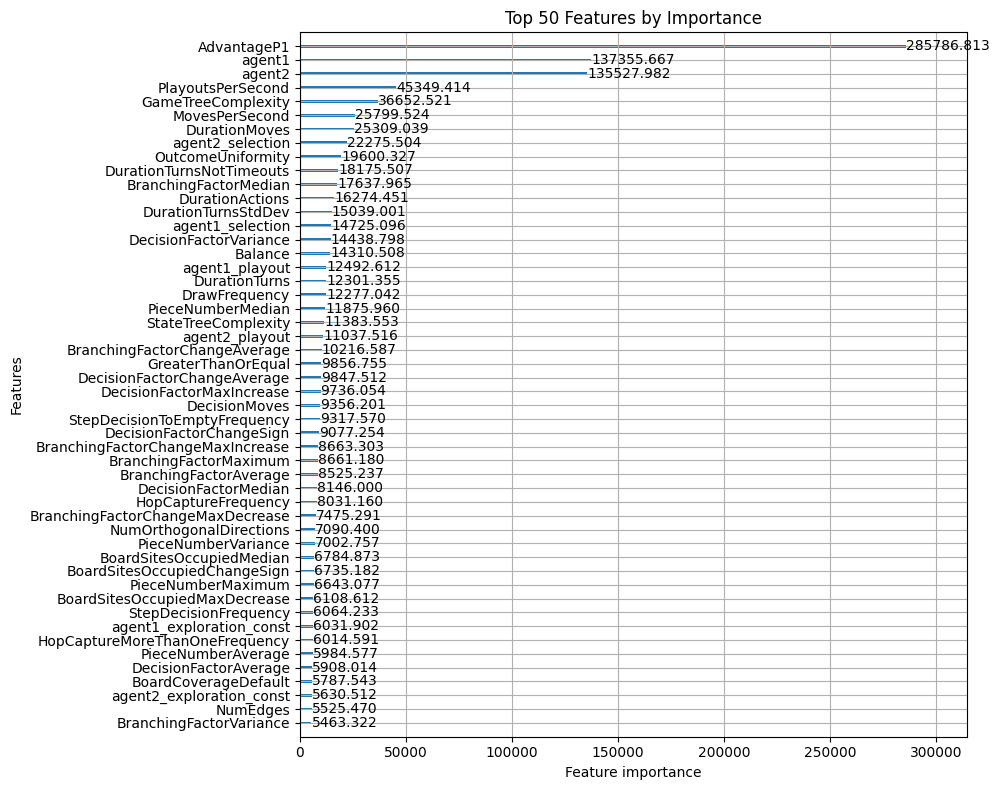

Fold 4 - RMSE: 0.4386599709029945
Fold 5


[100]	valid_0's rmse: 0.52037


[200]	valid_0's rmse: 0.497965


[300]	valid_0's rmse: 0.485178


[400]	valid_0's rmse: 0.476725


[500]	valid_0's rmse: 0.471707


[600]	valid_0's rmse: 0.466864


[700]	valid_0's rmse: 0.463272


[800]	valid_0's rmse: 0.460167


[900]	valid_0's rmse: 0.457621


[1000]	valid_0's rmse: 0.455385


[1100]	valid_0's rmse: 0.453558


[1200]	valid_0's rmse: 0.451858


[1300]	valid_0's rmse: 0.450226


[1400]	valid_0's rmse: 0.449159


[1500]	valid_0's rmse: 0.448134


[1600]	valid_0's rmse: 0.447275


[1700]	valid_0's rmse: 0.446342


[1800]	valid_0's rmse: 0.445632


[1900]	valid_0's rmse: 0.444735


[2000]	valid_0's rmse: 0.444229


[2100]	valid_0's rmse: 0.443742


[2200]	valid_0's rmse: 0.443249


[2300]	valid_0's rmse: 0.442685


[2400]	valid_0's rmse: 0.442257


[2500]	valid_0's rmse: 0.441887


[2600]	valid_0's rmse: 0.441496


[2700]	valid_0's rmse: 0.441183


[2800]	valid_0's rmse: 0.440766


[2900]	valid_0's rmse: 0.440476


[3000]	valid_0's rmse: 0.440291


[3100]	valid_0's rmse: 0.439974


[3200]	valid_0's rmse: 0.439762


[3300]	valid_0's rmse: 0.439483


[3400]	valid_0's rmse: 0.439242


[3500]	valid_0's rmse: 0.439057


[3600]	valid_0's rmse: 0.438813


[3700]	valid_0's rmse: 0.438603


[3800]	valid_0's rmse: 0.438409


[3900]	valid_0's rmse: 0.438158


[4000]	valid_0's rmse: 0.438044


[4100]	valid_0's rmse: 0.437883


[4200]	valid_0's rmse: 0.437725


[4300]	valid_0's rmse: 0.437511


[4400]	valid_0's rmse: 0.437339


[4500]	valid_0's rmse: 0.437201


[4600]	valid_0's rmse: 0.437069


[4700]	valid_0's rmse: 0.436947


[4800]	valid_0's rmse: 0.436728


[4900]	valid_0's rmse: 0.436621


[5000]	valid_0's rmse: 0.436499


[5100]	valid_0's rmse: 0.4365


[5200]	valid_0's rmse: 0.436429


[5300]	valid_0's rmse: 0.436333


[5400]	valid_0's rmse: 0.436272


[5500]	valid_0's rmse: 0.436153


[5600]	valid_0's rmse: 0.436081


[5700]	valid_0's rmse: 0.435938


[5800]	valid_0's rmse: 0.435875


[5900]	valid_0's rmse: 0.435831


[6000]	valid_0's rmse: 0.435707


[6100]	valid_0's rmse: 0.43561


[6200]	valid_0's rmse: 0.435501


[6300]	valid_0's rmse: 0.435462


[6400]	valid_0's rmse: 0.435365


[6500]	valid_0's rmse: 0.435314


[6600]	valid_0's rmse: 0.435289


[6700]	valid_0's rmse: 0.435184


[6800]	valid_0's rmse: 0.435186


[6900]	valid_0's rmse: 0.435151


[7000]	valid_0's rmse: 0.435161


[7100]	valid_0's rmse: 0.435137


[7200]	valid_0's rmse: 0.435128


[7300]	valid_0's rmse: 0.435081


[7400]	valid_0's rmse: 0.434981


[7500]	valid_0's rmse: 0.434953


[7600]	valid_0's rmse: 0.434948


[7700]	valid_0's rmse: 0.434919


[7800]	valid_0's rmse: 0.434916


[7900]	valid_0's rmse: 0.434882


[8000]	valid_0's rmse: 0.43484


[8100]	valid_0's rmse: 0.434825


[8200]	valid_0's rmse: 0.434801


[8300]	valid_0's rmse: 0.434805


[8400]	valid_0's rmse: 0.434785


[8500]	valid_0's rmse: 0.434756


[8600]	valid_0's rmse: 0.434742


[8700]	valid_0's rmse: 0.434723


[8800]	valid_0's rmse: 0.434696


[8900]	valid_0's rmse: 0.434661


[9000]	valid_0's rmse: 0.43463


[9100]	valid_0's rmse: 0.43459


[9200]	valid_0's rmse: 0.434588


[9300]	valid_0's rmse: 0.434613


[9400]	valid_0's rmse: 0.434611


[9500]	valid_0's rmse: 0.434607


[9600]	valid_0's rmse: 0.43456


[9700]	valid_0's rmse: 0.434538


[9800]	valid_0's rmse: 0.434512


[9900]	valid_0's rmse: 0.434457


[10000]	valid_0's rmse: 0.434421


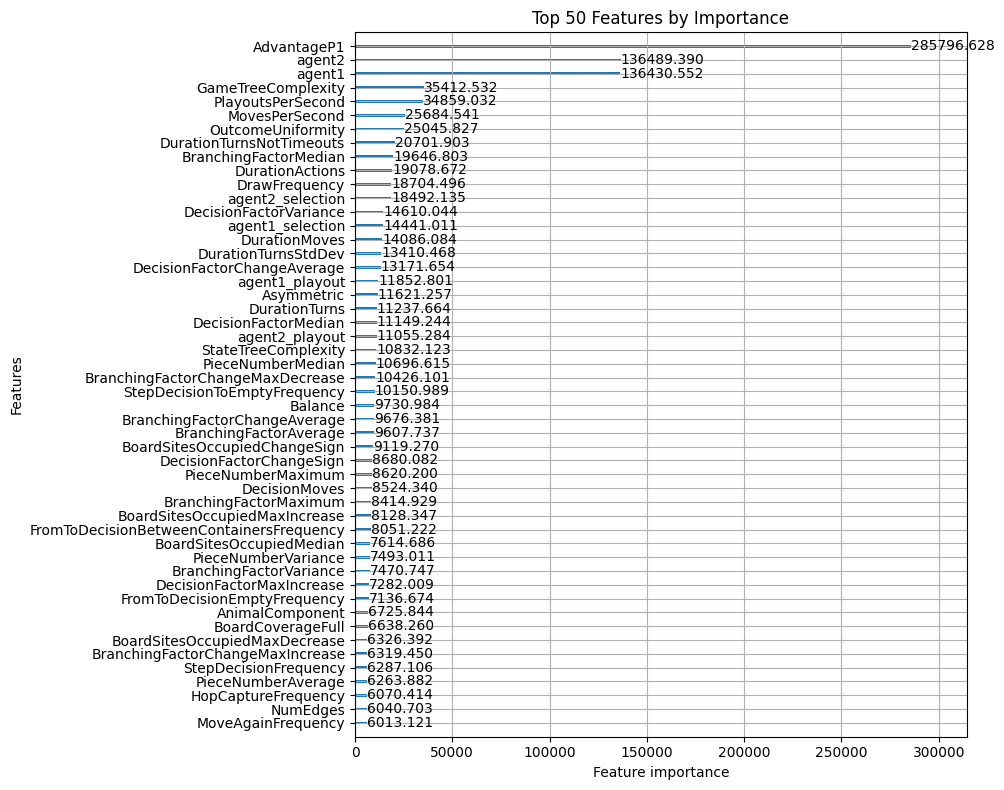

Fold 5 - RMSE: 0.43368899403193173
List of oof scores: [0.4097489747371242, 0.40266278750767576, 0.4359347133237793, 0.4386599709029945, 0.43368899403193173]
Average oof score: 0.4241390881007011


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.506787


[200]	valid_0's rmse: 0.483112


[300]	valid_0's rmse: 0.472629


[400]	valid_0's rmse: 0.465577


[500]	valid_0's rmse: 0.461364


[600]	valid_0's rmse: 0.458187


[700]	valid_0's rmse: 0.455396


[800]	valid_0's rmse: 0.453078


[900]	valid_0's rmse: 0.451022


[1000]	valid_0's rmse: 0.449633


[1100]	valid_0's rmse: 0.447943


[1200]	valid_0's rmse: 0.446382


[1300]	valid_0's rmse: 0.445229


[1400]	valid_0's rmse: 0.444152


[1500]	valid_0's rmse: 0.443311


[1600]	valid_0's rmse: 0.442415


[1700]	valid_0's rmse: 0.441807


[1800]	valid_0's rmse: 0.441218


[1900]	valid_0's rmse: 0.440764


[2000]	valid_0's rmse: 0.440202


[2100]	valid_0's rmse: 0.439785


[2200]	valid_0's rmse: 0.439364


[2300]	valid_0's rmse: 0.439104


[2400]	valid_0's rmse: 0.438911


[2500]	valid_0's rmse: 0.438481


[2600]	valid_0's rmse: 0.438191


[2700]	valid_0's rmse: 0.437846


[2800]	valid_0's rmse: 0.437625


[2900]	valid_0's rmse: 0.437561


[3000]	valid_0's rmse: 0.43729


[3100]	valid_0's rmse: 0.43714


[3200]	valid_0's rmse: 0.436904


[3300]	valid_0's rmse: 0.436716


[3400]	valid_0's rmse: 0.436583


[3500]	valid_0's rmse: 0.43643


[3600]	valid_0's rmse: 0.436328


[3700]	valid_0's rmse: 0.436179


[3800]	valid_0's rmse: 0.435952


[3900]	valid_0's rmse: 0.435786


[4000]	valid_0's rmse: 0.435613


[4100]	valid_0's rmse: 0.435561


[4200]	valid_0's rmse: 0.435551


[4300]	valid_0's rmse: 0.435444


[4400]	valid_0's rmse: 0.435313


[4500]	valid_0's rmse: 0.435141


[4600]	valid_0's rmse: 0.435084


[4700]	valid_0's rmse: 0.435015


[4800]	valid_0's rmse: 0.435004


[4900]	valid_0's rmse: 0.434914


[5000]	valid_0's rmse: 0.434808


[5100]	valid_0's rmse: 0.434748


[5200]	valid_0's rmse: 0.434655


[5300]	valid_0's rmse: 0.434487


[5400]	valid_0's rmse: 0.434427


[5500]	valid_0's rmse: 0.434357


[5600]	valid_0's rmse: 0.434242


[5700]	valid_0's rmse: 0.434197


[5800]	valid_0's rmse: 0.43415


[5900]	valid_0's rmse: 0.434111


[6000]	valid_0's rmse: 0.434093


[6100]	valid_0's rmse: 0.434008


[6200]	valid_0's rmse: 0.433953


[6300]	valid_0's rmse: 0.433965


[6400]	valid_0's rmse: 0.433897


[6500]	valid_0's rmse: 0.433844


[6600]	valid_0's rmse: 0.43381


[6700]	valid_0's rmse: 0.433695


[6800]	valid_0's rmse: 0.433615


[6900]	valid_0's rmse: 0.433541


[7000]	valid_0's rmse: 0.43348


[7100]	valid_0's rmse: 0.433416


[7200]	valid_0's rmse: 0.433408


[7300]	valid_0's rmse: 0.433381


[7400]	valid_0's rmse: 0.433293


[7500]	valid_0's rmse: 0.433246


[7600]	valid_0's rmse: 0.433286


[7700]	valid_0's rmse: 0.433287


[7800]	valid_0's rmse: 0.433279


[7900]	valid_0's rmse: 0.433284


[8000]	valid_0's rmse: 0.433242


[8100]	valid_0's rmse: 0.433221


[8200]	valid_0's rmse: 0.433176


[8300]	valid_0's rmse: 0.433152


[8400]	valid_0's rmse: 0.433143


[8500]	valid_0's rmse: 0.43318


[8600]	valid_0's rmse: 0.433103


[8700]	valid_0's rmse: 0.433086


[8800]	valid_0's rmse: 0.433019


[8900]	valid_0's rmse: 0.432981


[9000]	valid_0's rmse: 0.432952


[9100]	valid_0's rmse: 0.432938


[9200]	valid_0's rmse: 0.432942


[9300]	valid_0's rmse: 0.432876


[9400]	valid_0's rmse: 0.432872


[9500]	valid_0's rmse: 0.432808


[9600]	valid_0's rmse: 0.432775


[9700]	valid_0's rmse: 0.432762


[9800]	valid_0's rmse: 0.432771


[9900]	valid_0's rmse: 0.43271


[10000]	valid_0's rmse: 0.432687


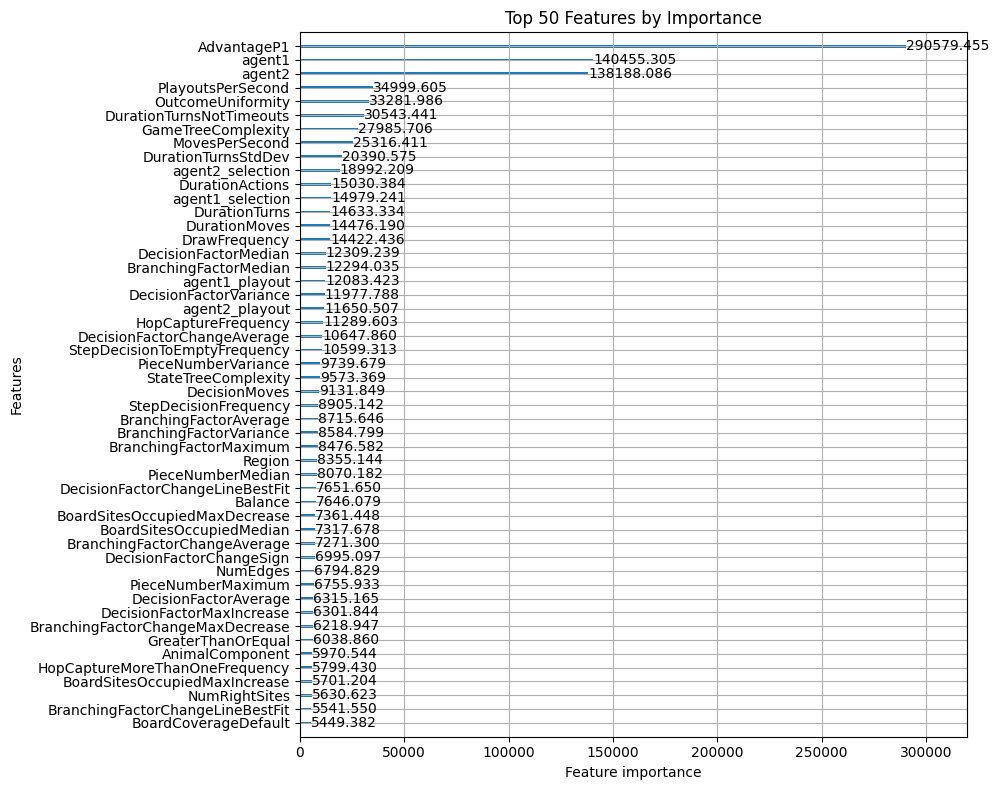

Fold 1 - RMSE: 0.4321421939745624
Fold 2


[100]	valid_0's rmse: 0.503695


[200]	valid_0's rmse: 0.480017


[300]	valid_0's rmse: 0.468217


[400]	valid_0's rmse: 0.459194


[500]	valid_0's rmse: 0.452899


[600]	valid_0's rmse: 0.447901


[700]	valid_0's rmse: 0.444018


[800]	valid_0's rmse: 0.440789


[900]	valid_0's rmse: 0.437972


[1000]	valid_0's rmse: 0.435643


[1100]	valid_0's rmse: 0.433536


[1200]	valid_0's rmse: 0.431728


[1300]	valid_0's rmse: 0.430231


[1400]	valid_0's rmse: 0.42929


[1500]	valid_0's rmse: 0.428281


[1600]	valid_0's rmse: 0.427303


[1700]	valid_0's rmse: 0.426449


[1800]	valid_0's rmse: 0.425736


[1900]	valid_0's rmse: 0.424933


[2000]	valid_0's rmse: 0.424206


[2100]	valid_0's rmse: 0.423623


[2200]	valid_0's rmse: 0.422963


[2300]	valid_0's rmse: 0.422311


[2400]	valid_0's rmse: 0.421749


[2500]	valid_0's rmse: 0.42125


[2600]	valid_0's rmse: 0.420855


[2700]	valid_0's rmse: 0.420464


[2800]	valid_0's rmse: 0.420209


[2900]	valid_0's rmse: 0.419836


[3000]	valid_0's rmse: 0.41947


[3100]	valid_0's rmse: 0.41919


[3200]	valid_0's rmse: 0.418849


[3300]	valid_0's rmse: 0.418482


[3400]	valid_0's rmse: 0.418184


[3500]	valid_0's rmse: 0.418013


[3600]	valid_0's rmse: 0.41775


[3700]	valid_0's rmse: 0.417597


[3800]	valid_0's rmse: 0.417331


[3900]	valid_0's rmse: 0.417221


[4000]	valid_0's rmse: 0.416951


[4100]	valid_0's rmse: 0.416678


[4200]	valid_0's rmse: 0.416425


[4300]	valid_0's rmse: 0.416138


[4400]	valid_0's rmse: 0.41596


[4500]	valid_0's rmse: 0.415745


[4600]	valid_0's rmse: 0.415539


[4700]	valid_0's rmse: 0.415486


[4800]	valid_0's rmse: 0.415394


[4900]	valid_0's rmse: 0.41528


[5000]	valid_0's rmse: 0.415132


[5100]	valid_0's rmse: 0.415053


[5200]	valid_0's rmse: 0.414902


[5300]	valid_0's rmse: 0.414692


[5400]	valid_0's rmse: 0.414678


[5500]	valid_0's rmse: 0.414605


[5600]	valid_0's rmse: 0.414426


[5700]	valid_0's rmse: 0.414353


[5800]	valid_0's rmse: 0.414282


[5900]	valid_0's rmse: 0.41419


[6000]	valid_0's rmse: 0.414117


[6100]	valid_0's rmse: 0.414126


[6200]	valid_0's rmse: 0.414013


[6300]	valid_0's rmse: 0.413939


[6400]	valid_0's rmse: 0.413886


[6500]	valid_0's rmse: 0.413767


[6600]	valid_0's rmse: 0.41373


[6700]	valid_0's rmse: 0.41363


[6800]	valid_0's rmse: 0.413503


[6900]	valid_0's rmse: 0.413453


[7000]	valid_0's rmse: 0.413445


[7100]	valid_0's rmse: 0.413413


[7200]	valid_0's rmse: 0.413359


[7300]	valid_0's rmse: 0.413301


[7400]	valid_0's rmse: 0.413267


[7500]	valid_0's rmse: 0.413153


[7600]	valid_0's rmse: 0.413084


[7700]	valid_0's rmse: 0.413003


[7800]	valid_0's rmse: 0.412912


[7900]	valid_0's rmse: 0.412916


[8000]	valid_0's rmse: 0.412889


[8100]	valid_0's rmse: 0.412851


[8200]	valid_0's rmse: 0.412842


[8300]	valid_0's rmse: 0.412785


[8400]	valid_0's rmse: 0.412744


[8500]	valid_0's rmse: 0.412647


[8600]	valid_0's rmse: 0.412629


[8700]	valid_0's rmse: 0.412572


[8800]	valid_0's rmse: 0.412591


[8900]	valid_0's rmse: 0.412557


[9000]	valid_0's rmse: 0.412544


[9100]	valid_0's rmse: 0.412532


[9200]	valid_0's rmse: 0.412562


[9300]	valid_0's rmse: 0.412592


[9400]	valid_0's rmse: 0.412545


[9500]	valid_0's rmse: 0.412532


[9600]	valid_0's rmse: 0.4125


[9700]	valid_0's rmse: 0.412449


[9800]	valid_0's rmse: 0.412446


[9900]	valid_0's rmse: 0.412425


[10000]	valid_0's rmse: 0.412417


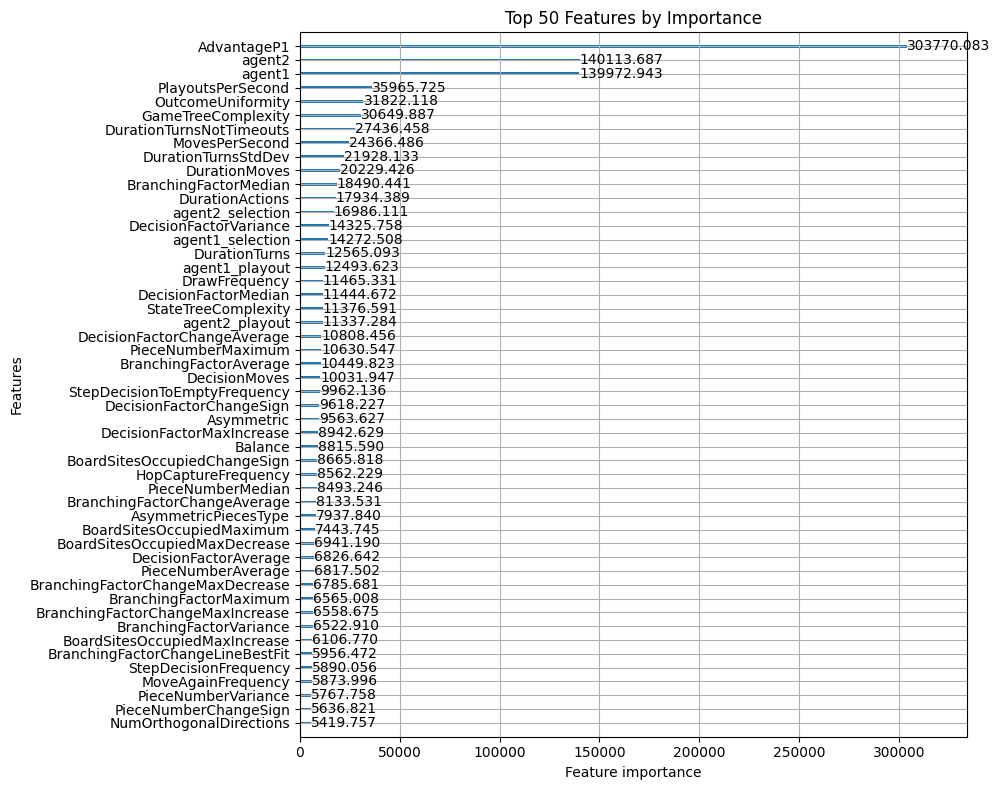

Fold 2 - RMSE: 0.41196343101803934
Fold 3


[100]	valid_0's rmse: 0.4975


[200]	valid_0's rmse: 0.473709


[300]	valid_0's rmse: 0.463176


[400]	valid_0's rmse: 0.455621


[500]	valid_0's rmse: 0.451291


[600]	valid_0's rmse: 0.448418


[700]	valid_0's rmse: 0.445914


[800]	valid_0's rmse: 0.443955


[900]	valid_0's rmse: 0.44215


[1000]	valid_0's rmse: 0.440609


[1100]	valid_0's rmse: 0.439054


[1200]	valid_0's rmse: 0.437824


[1300]	valid_0's rmse: 0.436594


[1400]	valid_0's rmse: 0.435608


[1500]	valid_0's rmse: 0.434688


[1600]	valid_0's rmse: 0.433827


[1700]	valid_0's rmse: 0.433194


[1800]	valid_0's rmse: 0.432685


[1900]	valid_0's rmse: 0.432211


[2000]	valid_0's rmse: 0.431836


[2100]	valid_0's rmse: 0.431348


[2200]	valid_0's rmse: 0.431001


[2300]	valid_0's rmse: 0.430696


[2400]	valid_0's rmse: 0.430473


[2500]	valid_0's rmse: 0.430086


[2600]	valid_0's rmse: 0.429721


[2700]	valid_0's rmse: 0.42956


[2800]	valid_0's rmse: 0.429427


[2900]	valid_0's rmse: 0.429173


[3000]	valid_0's rmse: 0.428925


[3100]	valid_0's rmse: 0.428813


[3200]	valid_0's rmse: 0.428667


[3300]	valid_0's rmse: 0.428394


[3400]	valid_0's rmse: 0.428205


[3500]	valid_0's rmse: 0.427963


[3600]	valid_0's rmse: 0.427792


[3700]	valid_0's rmse: 0.427678


[3800]	valid_0's rmse: 0.427537


[3900]	valid_0's rmse: 0.427394


[4000]	valid_0's rmse: 0.42724


[4100]	valid_0's rmse: 0.427134


[4200]	valid_0's rmse: 0.427013


[4300]	valid_0's rmse: 0.427004


[4400]	valid_0's rmse: 0.42684


[4500]	valid_0's rmse: 0.426759


[4600]	valid_0's rmse: 0.426662


[4700]	valid_0's rmse: 0.426579


[4800]	valid_0's rmse: 0.426431


[4900]	valid_0's rmse: 0.426339


[5000]	valid_0's rmse: 0.426224


[5100]	valid_0's rmse: 0.426091


[5200]	valid_0's rmse: 0.426039


[5300]	valid_0's rmse: 0.425934


[5400]	valid_0's rmse: 0.425854


[5500]	valid_0's rmse: 0.425703


[5600]	valid_0's rmse: 0.425644


[5700]	valid_0's rmse: 0.42554


[5800]	valid_0's rmse: 0.42547


[5900]	valid_0's rmse: 0.425408


[6000]	valid_0's rmse: 0.425291


[6100]	valid_0's rmse: 0.425191


[6200]	valid_0's rmse: 0.425199


[6300]	valid_0's rmse: 0.425097


[6400]	valid_0's rmse: 0.425077


[6500]	valid_0's rmse: 0.425035


[6600]	valid_0's rmse: 0.424995


[6700]	valid_0's rmse: 0.424906


[6800]	valid_0's rmse: 0.424883


[6900]	valid_0's rmse: 0.424791


[7000]	valid_0's rmse: 0.424744


[7100]	valid_0's rmse: 0.424712


[7200]	valid_0's rmse: 0.4247


[7300]	valid_0's rmse: 0.42462


[7400]	valid_0's rmse: 0.424624


[7500]	valid_0's rmse: 0.424572


[7600]	valid_0's rmse: 0.424615


[7700]	valid_0's rmse: 0.424607


[7800]	valid_0's rmse: 0.424557


[7900]	valid_0's rmse: 0.424514


[8000]	valid_0's rmse: 0.424456


[8100]	valid_0's rmse: 0.424398


[8200]	valid_0's rmse: 0.424402


[8300]	valid_0's rmse: 0.424392


[8400]	valid_0's rmse: 0.424329


[8500]	valid_0's rmse: 0.424273


[8600]	valid_0's rmse: 0.424199


[8700]	valid_0's rmse: 0.424244


[8800]	valid_0's rmse: 0.424225


[8900]	valid_0's rmse: 0.424131


[9000]	valid_0's rmse: 0.424135


[9100]	valid_0's rmse: 0.424106


[9200]	valid_0's rmse: 0.424045


[9300]	valid_0's rmse: 0.424025


[9400]	valid_0's rmse: 0.424029


[9500]	valid_0's rmse: 0.424048


[9600]	valid_0's rmse: 0.42405


[9700]	valid_0's rmse: 0.424056


[9800]	valid_0's rmse: 0.424037


[9900]	valid_0's rmse: 0.424001


[10000]	valid_0's rmse: 0.423944


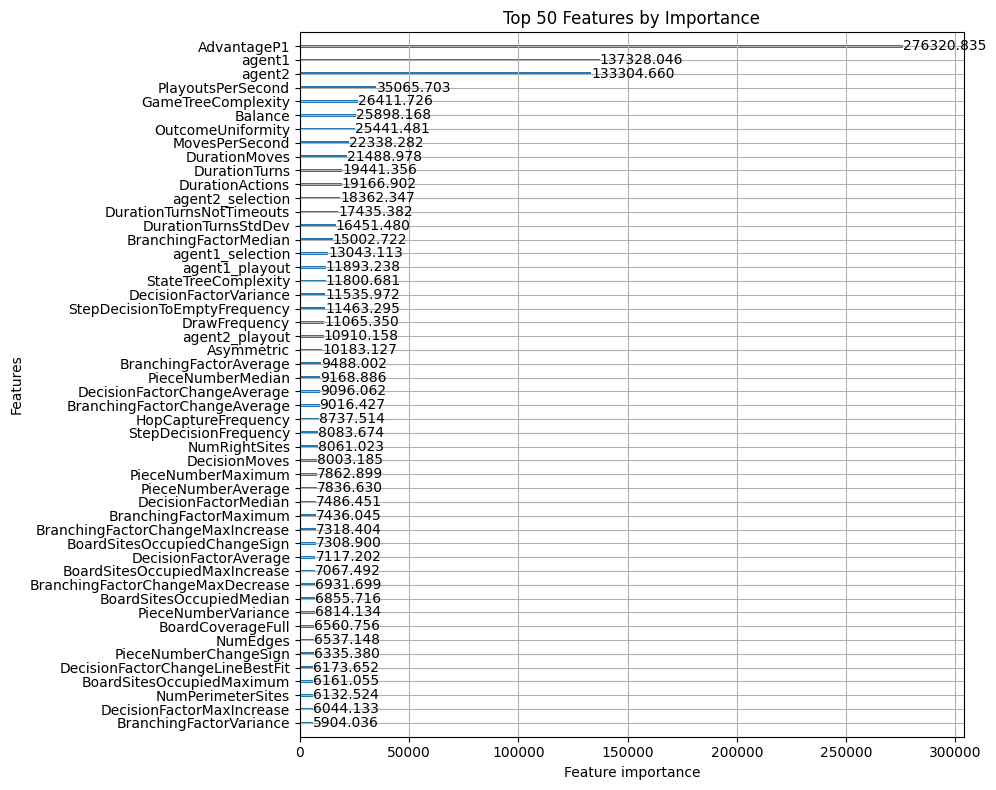

Fold 3 - RMSE: 0.4234969153700024
Fold 4


[100]	valid_0's rmse: 0.492345


[200]	valid_0's rmse: 0.46864


[300]	valid_0's rmse: 0.457953


[400]	valid_0's rmse: 0.450658


[500]	valid_0's rmse: 0.44691


[600]	valid_0's rmse: 0.444472


[700]	valid_0's rmse: 0.441181


[800]	valid_0's rmse: 0.439011


[900]	valid_0's rmse: 0.437091


[1000]	valid_0's rmse: 0.435448


[1100]	valid_0's rmse: 0.434201


[1200]	valid_0's rmse: 0.432926


[1300]	valid_0's rmse: 0.431902


[1400]	valid_0's rmse: 0.430956


[1500]	valid_0's rmse: 0.430094


[1600]	valid_0's rmse: 0.429415


[1700]	valid_0's rmse: 0.428697


[1800]	valid_0's rmse: 0.428207


[1900]	valid_0's rmse: 0.42765


[2000]	valid_0's rmse: 0.427046


[2100]	valid_0's rmse: 0.426727


[2200]	valid_0's rmse: 0.426223


[2300]	valid_0's rmse: 0.425851


[2400]	valid_0's rmse: 0.42559


[2500]	valid_0's rmse: 0.425138


[2600]	valid_0's rmse: 0.424932


[2700]	valid_0's rmse: 0.424609


[2800]	valid_0's rmse: 0.424314


[2900]	valid_0's rmse: 0.423924


[3000]	valid_0's rmse: 0.423724


[3100]	valid_0's rmse: 0.423539


[3200]	valid_0's rmse: 0.423459


[3300]	valid_0's rmse: 0.423236


[3400]	valid_0's rmse: 0.423072


[3500]	valid_0's rmse: 0.42285


[3600]	valid_0's rmse: 0.422696


[3700]	valid_0's rmse: 0.422531


[3800]	valid_0's rmse: 0.422464


[3900]	valid_0's rmse: 0.422334


[4000]	valid_0's rmse: 0.422206


[4100]	valid_0's rmse: 0.422041


[4200]	valid_0's rmse: 0.421876


[4300]	valid_0's rmse: 0.42176


[4400]	valid_0's rmse: 0.421659


[4500]	valid_0's rmse: 0.421507


[4600]	valid_0's rmse: 0.421495


[4700]	valid_0's rmse: 0.421454


[4800]	valid_0's rmse: 0.421385


[4900]	valid_0's rmse: 0.421292


[5000]	valid_0's rmse: 0.421273


[5100]	valid_0's rmse: 0.421261


[5200]	valid_0's rmse: 0.421231


[5300]	valid_0's rmse: 0.421127


[5400]	valid_0's rmse: 0.421014


[5500]	valid_0's rmse: 0.42096


[5600]	valid_0's rmse: 0.420881


[5700]	valid_0's rmse: 0.420783


[5800]	valid_0's rmse: 0.420726


[5900]	valid_0's rmse: 0.420696


[6000]	valid_0's rmse: 0.420616


[6100]	valid_0's rmse: 0.420564


[6200]	valid_0's rmse: 0.420463


[6300]	valid_0's rmse: 0.420388


[6400]	valid_0's rmse: 0.420298


[6500]	valid_0's rmse: 0.420254


[6600]	valid_0's rmse: 0.420215


[6700]	valid_0's rmse: 0.42022


[6800]	valid_0's rmse: 0.420178


[6900]	valid_0's rmse: 0.420127


[7000]	valid_0's rmse: 0.420101


[7100]	valid_0's rmse: 0.420084


[7200]	valid_0's rmse: 0.420023


[7300]	valid_0's rmse: 0.420004


[7400]	valid_0's rmse: 0.419994


[7500]	valid_0's rmse: 0.419975


[7600]	valid_0's rmse: 0.419954


[7700]	valid_0's rmse: 0.419931


[7800]	valid_0's rmse: 0.419882


[7900]	valid_0's rmse: 0.419881


[8000]	valid_0's rmse: 0.419863


[8100]	valid_0's rmse: 0.419827


[8200]	valid_0's rmse: 0.419804


[8300]	valid_0's rmse: 0.419756


[8400]	valid_0's rmse: 0.419744


[8500]	valid_0's rmse: 0.419758


[8600]	valid_0's rmse: 0.419752


[8700]	valid_0's rmse: 0.419749


[8800]	valid_0's rmse: 0.41971


[8900]	valid_0's rmse: 0.419706


[9000]	valid_0's rmse: 0.41968


[9100]	valid_0's rmse: 0.419654


[9200]	valid_0's rmse: 0.419641


[9300]	valid_0's rmse: 0.419618


[9400]	valid_0's rmse: 0.419584


[9500]	valid_0's rmse: 0.419574


[9600]	valid_0's rmse: 0.419549


[9700]	valid_0's rmse: 0.419484


[9800]	valid_0's rmse: 0.419458


[9900]	valid_0's rmse: 0.419512


[10000]	valid_0's rmse: 0.419512


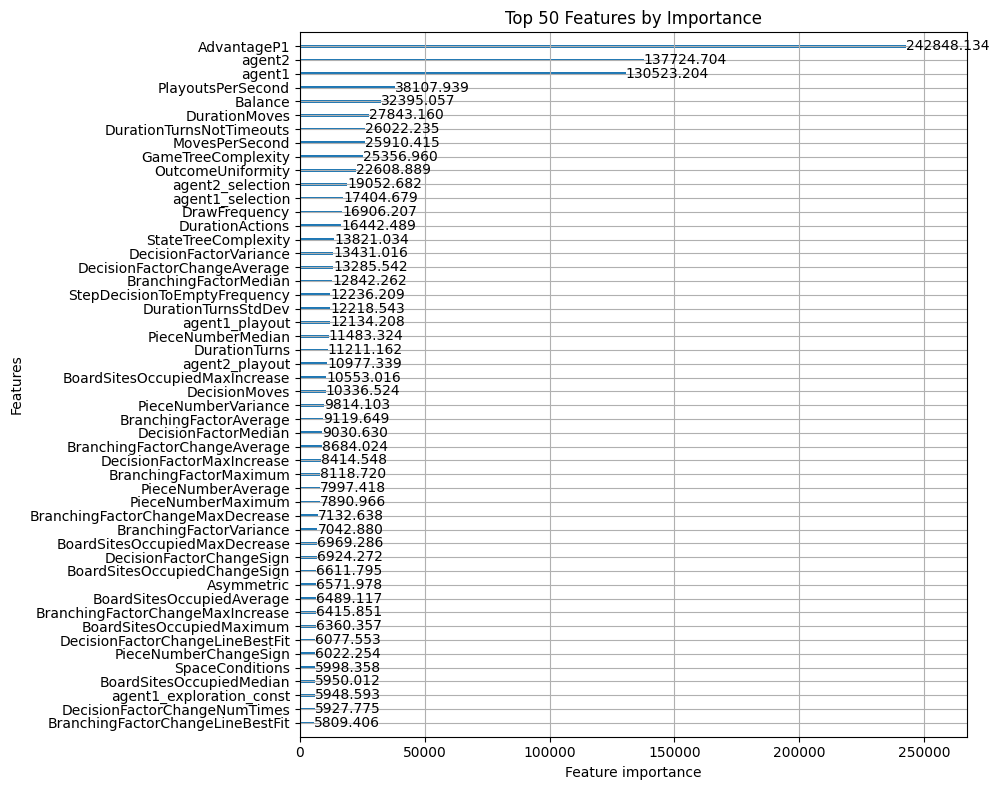

Fold 4 - RMSE: 0.4188605495625717
Fold 5


[100]	valid_0's rmse: 0.511822


[200]	valid_0's rmse: 0.492259


[300]	valid_0's rmse: 0.481159


[400]	valid_0's rmse: 0.472185


[500]	valid_0's rmse: 0.466897


[600]	valid_0's rmse: 0.462502


[700]	valid_0's rmse: 0.459133


[800]	valid_0's rmse: 0.455927


[900]	valid_0's rmse: 0.453819


[1000]	valid_0's rmse: 0.451663


[1100]	valid_0's rmse: 0.449928


[1200]	valid_0's rmse: 0.448368


[1300]	valid_0's rmse: 0.446856


[1400]	valid_0's rmse: 0.44576


[1500]	valid_0's rmse: 0.444789


[1600]	valid_0's rmse: 0.443839


[1700]	valid_0's rmse: 0.442848


[1800]	valid_0's rmse: 0.44217


[1900]	valid_0's rmse: 0.441474


[2000]	valid_0's rmse: 0.440899


[2100]	valid_0's rmse: 0.44042


[2200]	valid_0's rmse: 0.439818


[2300]	valid_0's rmse: 0.439335


[2400]	valid_0's rmse: 0.438958


[2500]	valid_0's rmse: 0.438656


[2600]	valid_0's rmse: 0.438252


[2700]	valid_0's rmse: 0.437942


[2800]	valid_0's rmse: 0.437529


[2900]	valid_0's rmse: 0.437264


[3000]	valid_0's rmse: 0.437


[3100]	valid_0's rmse: 0.436686


[3200]	valid_0's rmse: 0.436381


[3300]	valid_0's rmse: 0.436117


[3400]	valid_0's rmse: 0.435883


[3500]	valid_0's rmse: 0.435637


[3600]	valid_0's rmse: 0.435533


[3700]	valid_0's rmse: 0.435282


[3800]	valid_0's rmse: 0.435028


[3900]	valid_0's rmse: 0.434891


[4000]	valid_0's rmse: 0.434755


[4100]	valid_0's rmse: 0.43453


[4200]	valid_0's rmse: 0.434357


[4300]	valid_0's rmse: 0.434283


[4400]	valid_0's rmse: 0.434137


[4500]	valid_0's rmse: 0.433921


[4600]	valid_0's rmse: 0.43385


[4700]	valid_0's rmse: 0.43372


[4800]	valid_0's rmse: 0.433582


[4900]	valid_0's rmse: 0.43348


[5000]	valid_0's rmse: 0.433338


[5100]	valid_0's rmse: 0.433255


[5200]	valid_0's rmse: 0.433174


[5300]	valid_0's rmse: 0.433142


[5400]	valid_0's rmse: 0.433096


[5500]	valid_0's rmse: 0.432967


[5600]	valid_0's rmse: 0.432871


[5700]	valid_0's rmse: 0.432727


[5800]	valid_0's rmse: 0.432684


[5900]	valid_0's rmse: 0.432573


[6000]	valid_0's rmse: 0.432509


[6100]	valid_0's rmse: 0.432458


[6200]	valid_0's rmse: 0.432345


[6300]	valid_0's rmse: 0.432273


[6400]	valid_0's rmse: 0.432234


[6500]	valid_0's rmse: 0.432172


[6600]	valid_0's rmse: 0.432122


[6700]	valid_0's rmse: 0.432075


[6800]	valid_0's rmse: 0.432012


[6900]	valid_0's rmse: 0.431991


[7000]	valid_0's rmse: 0.431926


[7100]	valid_0's rmse: 0.431929


[7200]	valid_0's rmse: 0.431845


[7300]	valid_0's rmse: 0.431844


[7400]	valid_0's rmse: 0.431784


[7500]	valid_0's rmse: 0.431677


[7600]	valid_0's rmse: 0.431689


[7700]	valid_0's rmse: 0.431664


[7800]	valid_0's rmse: 0.431543


[7900]	valid_0's rmse: 0.431469


[8000]	valid_0's rmse: 0.431421


[8100]	valid_0's rmse: 0.431374


[8200]	valid_0's rmse: 0.43138


[8300]	valid_0's rmse: 0.431314


[8400]	valid_0's rmse: 0.431259


[8500]	valid_0's rmse: 0.43112


[8600]	valid_0's rmse: 0.431099


[8700]	valid_0's rmse: 0.431116


[8800]	valid_0's rmse: 0.431069


[8900]	valid_0's rmse: 0.431053


[9000]	valid_0's rmse: 0.431044


[9100]	valid_0's rmse: 0.430995


[9200]	valid_0's rmse: 0.43099


[9300]	valid_0's rmse: 0.430928


[9400]	valid_0's rmse: 0.430878


[9500]	valid_0's rmse: 0.43082


[9600]	valid_0's rmse: 0.430848


[9700]	valid_0's rmse: 0.430833


[9800]	valid_0's rmse: 0.430848


[9900]	valid_0's rmse: 0.43086


[10000]	valid_0's rmse: 0.43088


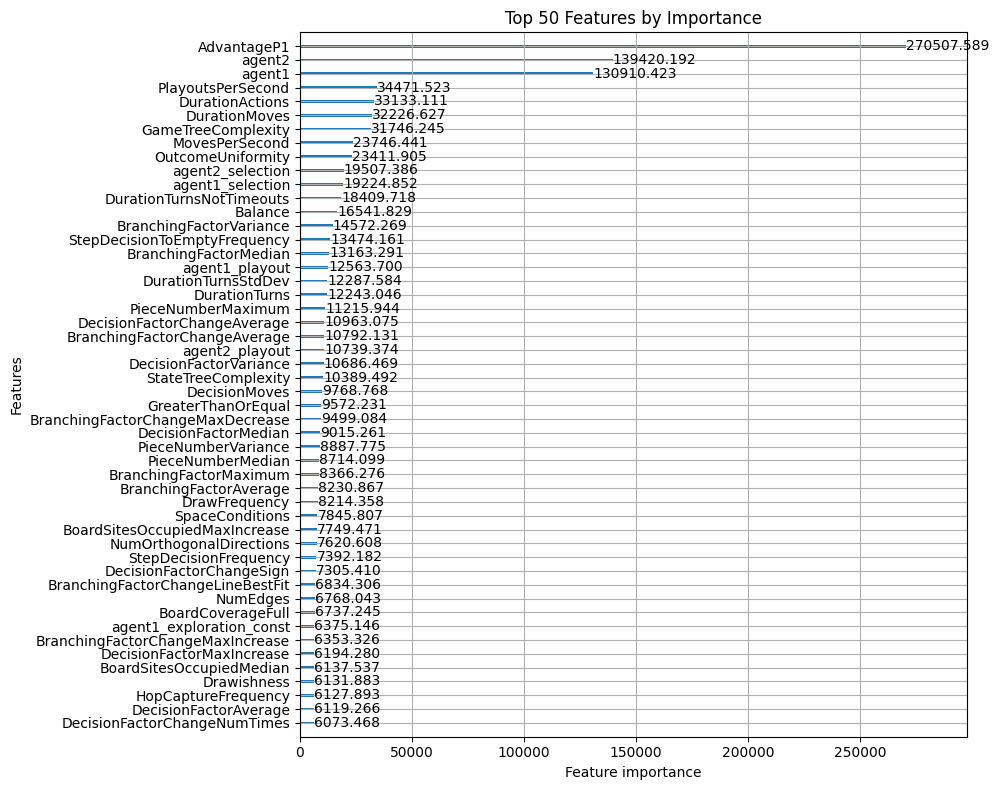

Fold 5 - RMSE: 0.4301430528742226
List of oof scores: [0.4321421939745624, 0.41196343101803934, 0.4234969153700024, 0.4188605495625717, 0.4301430528742226]
Average oof score: 0.4233212285598797


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4277
Score: 0.4540
Score: 0.4382
Score: 0.4362
Score: 0.4078
Average CV1 Score: 0.4328

CV2 OOF Scores:
Score: 0.4097
Score: 0.4027
Score: 0.4359
Score: 0.4387
Score: 0.4337
Average CV2 Score: 0.4241

CV3 OOF Scores:
Score: 0.4321
Score: 0.4120
Score: 0.4235
Score: 0.4189
Score: 0.4301
Average CV3 Score: 0.4233


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

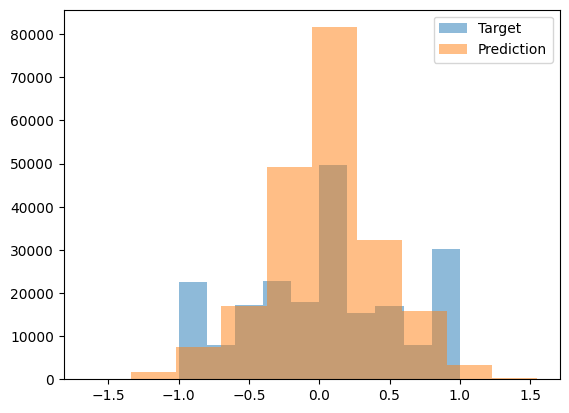

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.128328       │
│ 233235 ┆ -0.185666      │
│ 233236 ┆ -0.018711      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***